##### GOODREADS RATINGS
https://www.kaggle.com/code/miltonsuggs/02-goodreads-ratings

In [76]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

import plotly.express as px
import missingno as msno
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import datetime

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Features Description:

* bookID
    Contains the unique ID for each book/series
* title
    contains the titles of the books
* authors
    contains the author of the particular book
* average_rating 
    the average rating of the books, as decided by the users
* ISBN ISBN(10) 
    number, tells the information about a book - such as edition and publisher
* ISBN 13 
    The new format for ISBN, implemented in 2007. 13 digits
* language_code 
    Tells the language for the books
* Num_pages 
    Contains the number of pages for the book
* Ratings_count 
    Contains the number of ratings given for the book
* text_reviews_count 
    Has the count of reviews left by users

In [78]:
df = pd.read_csv("books.csv",on_bad_lines = 'skip')
df.head(1)

bookID                                              title  \
0       1  Harry Potter and the Half-Blood Prince (Harry ...   

                      authors  average_rating        isbn         isbn13  \
0  J.K. Rowling/Mary GrandPré            4.57  0439785960  9780439785969   

  language_code    num_pages  ratings_count  text_reviews_count  \
0           eng          652        2095690               27591   

  publication_date        publisher  
0        9/16/2006  Scholastic Inc.

# EDA

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11123 entries, 0 to 11122
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              11123 non-null  int64  
 1   title               11123 non-null  object 
 2   authors             11123 non-null  object 
 3   average_rating      11123 non-null  float64
 4   isbn                11123 non-null  object 
 5   isbn13              11123 non-null  int64  
 6   language_code       11123 non-null  object 
 7     num_pages         11123 non-null  int64  
 8   ratings_count       11123 non-null  int64  
 9   text_reviews_count  11123 non-null  int64  
 10  publication_date    11123 non-null  object 
 11  publisher           11123 non-null  object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.0+ MB


In [80]:
df.shape

(11123, 12)

In [81]:
df.describe()

bookID  average_rating        isbn13     num_pages  \
count  11123.000000    11123.000000  1.112300e+04  11123.000000   
mean   21310.856963        3.934075  9.759880e+12    336.405556   
std    13094.727252        0.350485  4.429758e+11    241.152626   
min        1.000000        0.000000  8.987060e+09      0.000000   
25%    10277.500000        3.770000  9.780345e+12    192.000000   
50%    20287.000000        3.960000  9.780582e+12    299.000000   
75%    32104.500000        4.140000  9.780872e+12    416.000000   
max    45641.000000        5.000000  9.790008e+12   6576.000000   

       ratings_count  text_reviews_count  
count   1.112300e+04        11123.000000  
mean    1.794285e+04          542.048099  
std     1.124992e+05         2576.619589  
min     0.000000e+00            0.000000  
25%     1.040000e+02            9.000000  
50%     7.450000e+02           47.000000  
75%     5.000500e+03          238.000000  
max     4.597666e+06        94265.000000

In [82]:
df.isnull().sum()

bookID                0
title                 0
authors               0
average_rating        0
isbn                  0
isbn13                0
language_code         0
  num_pages           0
ratings_count         0
text_reviews_count    0
publication_date      0
publisher             0
dtype: int64

In [83]:
df.duplicated().sum()

0

### CARDINALITY

In [17]:
cardinality={}
for col in df.columns:
    cardinality[col] = df[col].nunique()

cardinality

{'bookID': 11123,
 'title': 10348,
 'authors': 6639,
 'average_rating': 209,
 'isbn': 11123,
 'isbn13': 11123,
 'language_code': 27,
 '  num_pages': 997,
 'ratings_count': 5294,
 'text_reviews_count': 1822,
 'publication_date': 3679,
 'publisher': 2290}

#### CONVERT DATES TO DATETIME FORMAT

In [18]:
#CHANGE DATE FORMAT FROM M/D/YYYY TO MM/DD/YYYY

for row in df['publication_date']:
    if len(row) == 8:
        df['publication_date'].replace(row, ('0' + row), inplace=True)
        
for row in df['publication_date']:
    if row[1] == '/':
        df['publication_date'].replace(row, ('0' + row), inplace=True)

for row in df['publication_date']:
    if row[4] == '/':
        df['publication_date'].replace(row, (row[:3] + '0' + row[3:]), inplace=True)        

In [84]:
# CHANGE DATE TYPE FROM STR TO DATETIME

dates = pd.Series(df['publication_date'])
dates = pd.to_datetime(dates, errors='coerce')
df['publication_date'] = dates

In [85]:
#SEPARATE DAY, MONTH, AND YEAR INTO INDIVIDUAL COLUMNS

df['publication_year'] = pd.to_datetime(df['publication_date']).dt.year
df['publication_year'] = df['publication_year'].fillna(0)
df['publication_year'] = df['publication_year'].astype(int)

df['publication_month'] = pd.to_datetime(df['publication_date']).dt.month
df['publication_month'] = df['publication_month'].fillna(0)
df['publication_month'] = df['publication_month'].astype(int)

df['pub_month_name'] = df['publication_date'].dt.strftime('%B')
df['pub_month_num'] = df['publication_date'].dt.strftime('%m')
df['publication_weekday'] = df['publication_date'].dt.strftime('%A')  
df['pub_date_num'] = df['publication_date'].dt.strftime('%d')
df['pub_year_month'] = df.publication_date.dt.to_period("M")

In [86]:
# REMOVE ROWS WITH NULL DATE VALUES

df = df[df['publication_year'] != 0]

df['publication_year'].isnull().value_counts()

publication_year
False    11121
Name: count, dtype: int64

#### CREATE BINS FOR AVERAGE RATINGS

In [87]:
bins = np.linspace(0, 5, 6)
group_names = ['btw 0 & 1', 'btw 1 & 2', 'btw 2 & 3', 'btw 3 & 4', 'btw 4 & 5']
df['ratings_binned'] = pd.cut(df['average_rating'], bins, labels=group_names, include_lowest=True)

In [88]:
#Remove Mary GrandPre from Harry Potter novels

df.replace('J.K. Rowling-Mary GrandPré', 'J.K. Rowling', inplace=True)

## Visualization

### The 20 books that appear most frequently within the Goodreads data set.

In [91]:
title_count = df.groupby(['title'])[['bookID']].agg('count').reset_index()
title_count.rename(columns={'bookID':'count'}, inplace=True)
title_count = title_count.sort_values('count', ascending=False)
title_count = title_count.reset_index().drop(['index'], axis=1)
title_count = title_count.head(20)

Text(0, 0.5, 'TITLES')

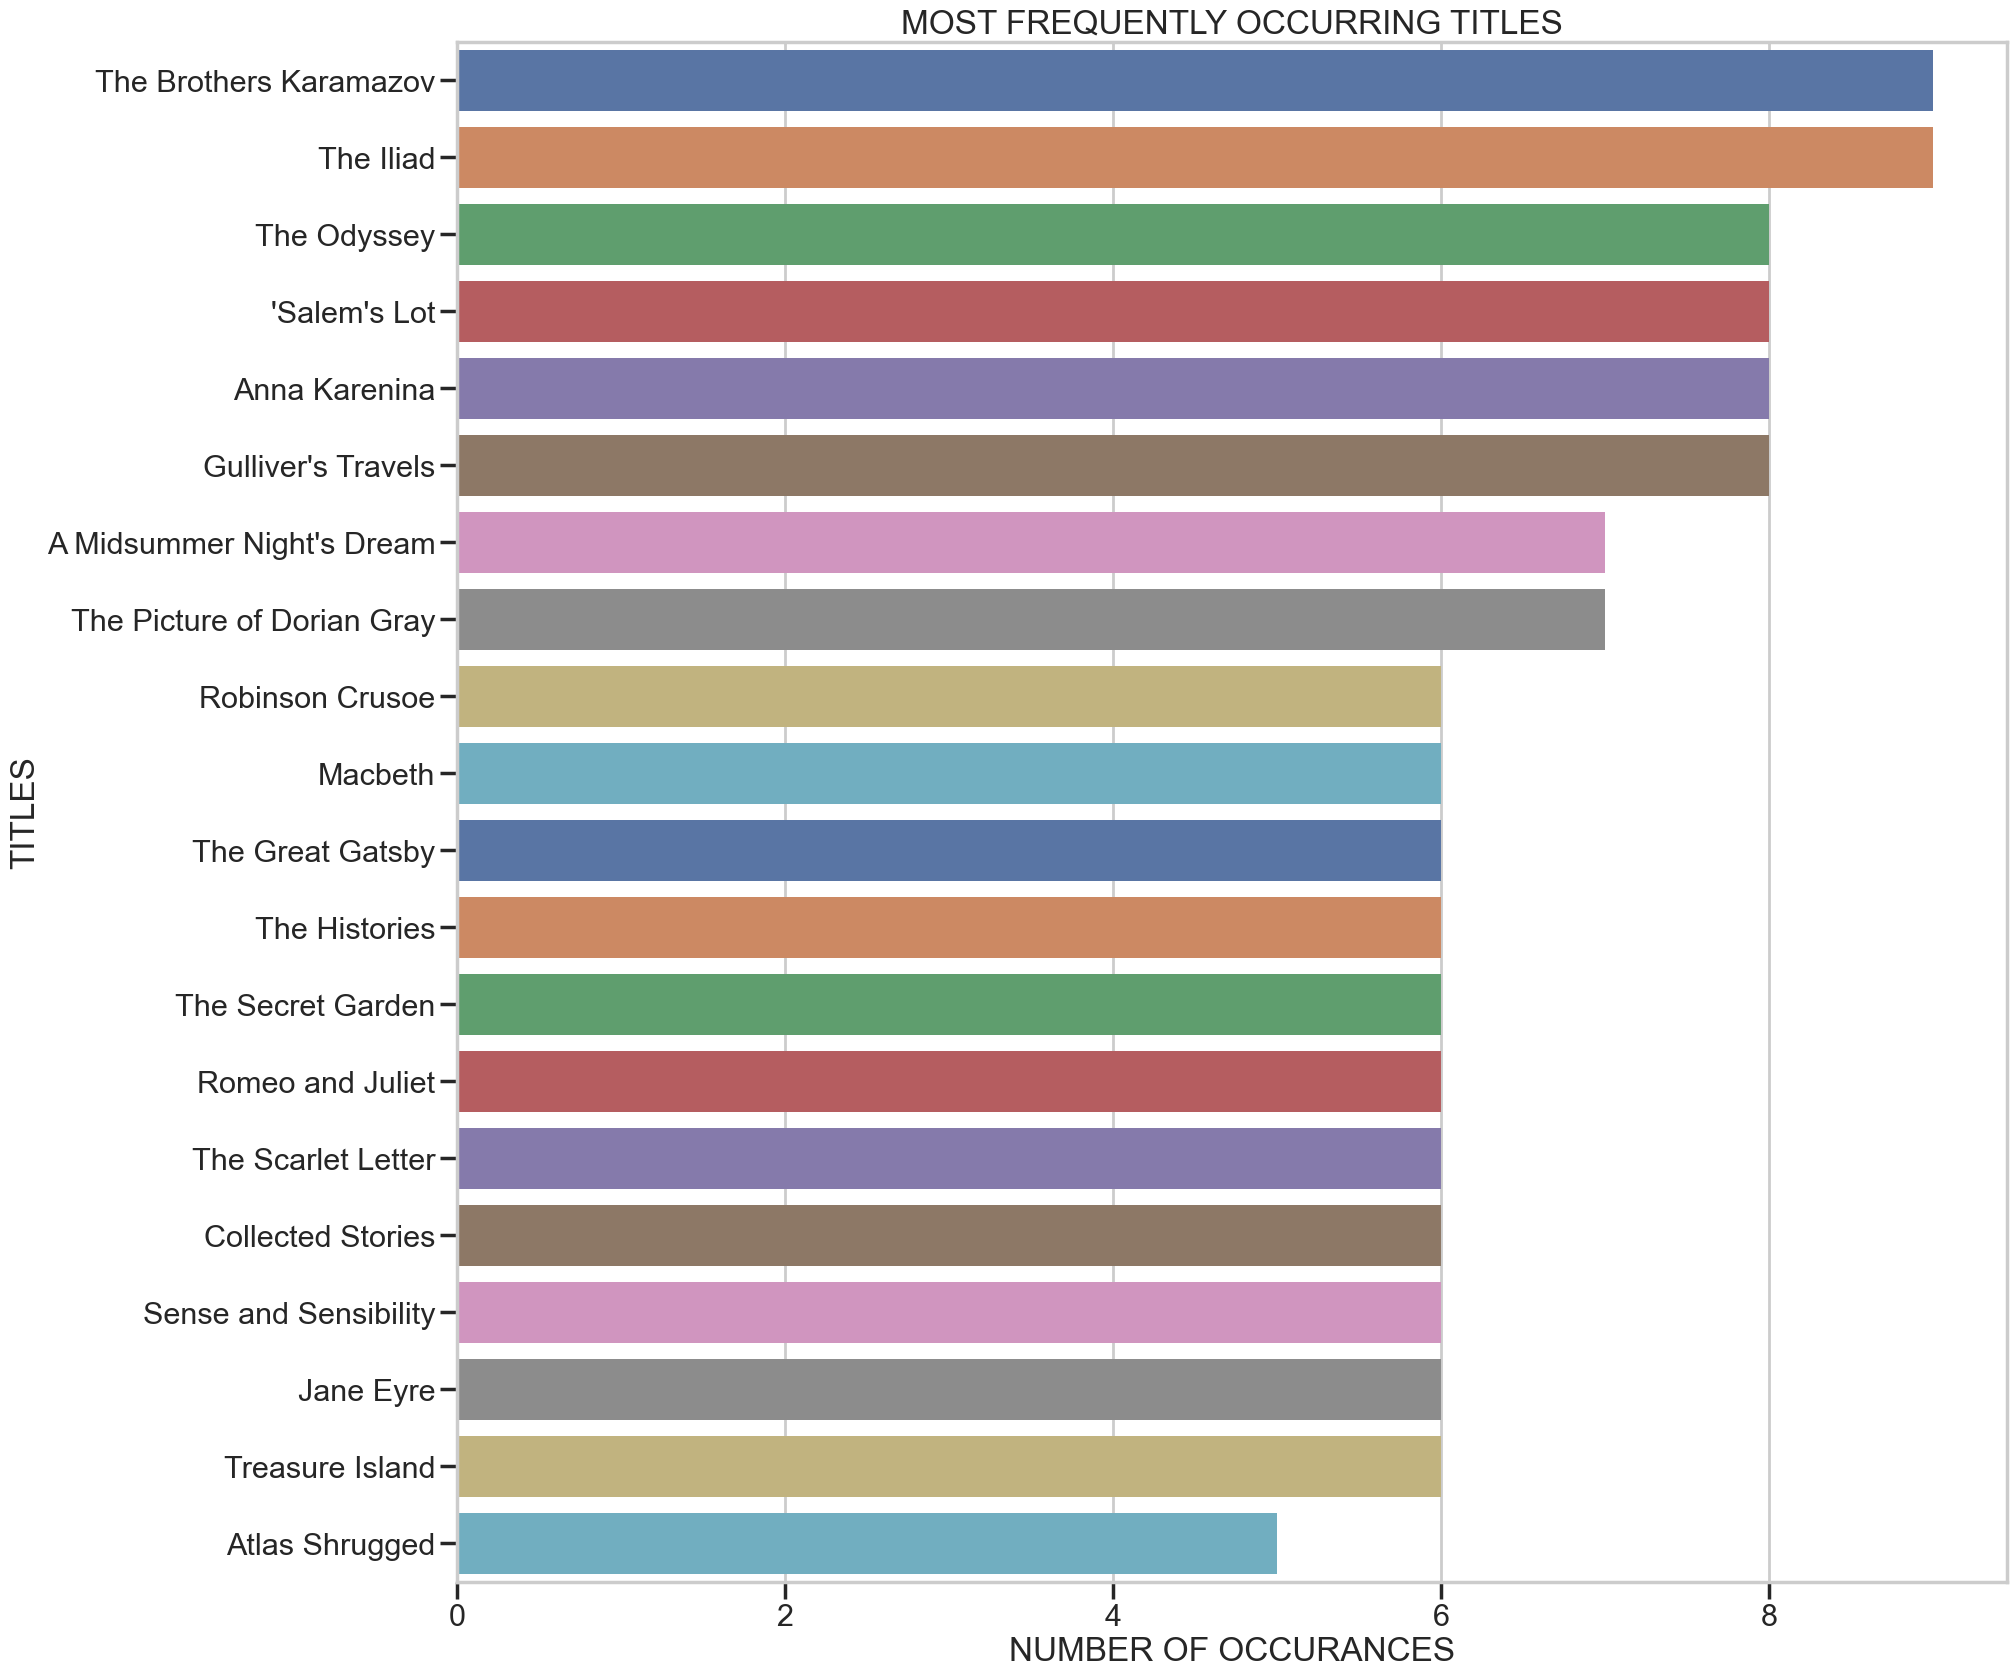

In [92]:
sns.set_context('poster')
plt.figure(figsize=(20,20))

x=title_count['count']
y=title_count['title']

ax = sns.barplot(x=x, y=y, palette='deep')


ax.set_title("MOST FREQUENTLY OCCURRING TITLES")
ax.set_xlabel("NUMBER OF OCCURANCES")
ax.set_ylabel("TITLES")
# plt.show()

C:\Users\alhai\AppData\Local\Temp\ipykernel_26032\2988746623.py:3: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




Text(0.5, 0, 'Average rating')

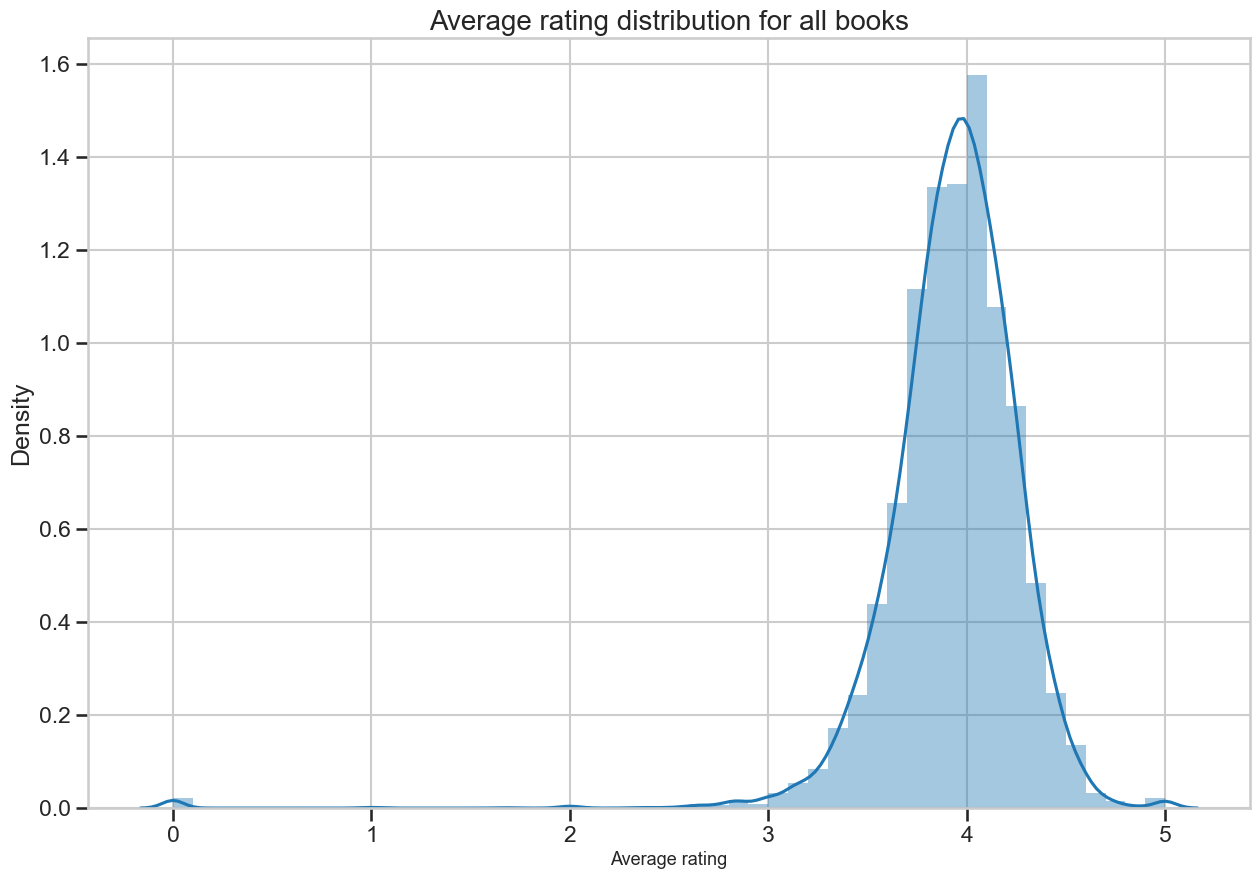

In [116]:
df.average_rating = df.average_rating.astype(float)
fig, ax = plt.subplots(figsize=[15,10])
sns.distplot(df['average_rating'],ax=ax)
ax.set_title('Average rating distribution for all books',fontsize=20)
ax.set_xlabel('Average rating',fontsize=13)

### 20 MOST RATED TITLES

In [95]:
most_rated_titles = df[['title', 'ratings_count', 'publication_year']].sort_values('ratings_count', ascending = False).reset_index()
most_rated_titles = most_rated_titles.drop(['index'], axis=1)
most_rated_titles = most_rated_titles.head(20)
most_rated_titles

title  ratings_count  \
0                             Twilight (Twilight  #1)        4597666   
1                 The Hobbit  or There and Back Again        2530894   
2                              The Catcher in the Rye        2457092   
3                Angels & Demons (Robert Langdon  #1)        2418736   
4   Harry Potter and the Prisoner of Azkaban (Harr...        2339585   
5   Harry Potter and the Chamber of Secrets (Harry...        2293963   
6   Harry Potter and the Order of the Phoenix (Har...        2153167   
7   The Fellowship of the Ring (The Lord of the Ri...        2128944   
8                                         Animal Farm        2111750   
9   Harry Potter and the Half-Blood Prince (Harry ...        2095690   
10                                  Lord of the Flies        2036679   
11                                   Romeo and Juliet        1893917   
12  The Lightning Thief (Percy Jackson and the Oly...        1766725   
13                                    Of Mice and Men        1755253   
14             The Da Vinci Code (Robert Langdon  #2)        1679706   
15                                      The Alchemist        1631221   
16                          The Giver (The Giver  #1)        1585589   
17                                     The Book Thief        1516367   
18                                       Little Women        1479727   
19                                          Jane Eyre        1409369   

    publication_year  
0               2006  
1               2002  
2               2001  
3               2006  
4               2004  
5               1999  
6               2004  
7               2003  
8               2003  
9               2006  
10              1999  
11              2004  
12              2006  
13              2002  
14              2006  
15              1993  
16              2006  
17              2006  
18              2004  
19              2003

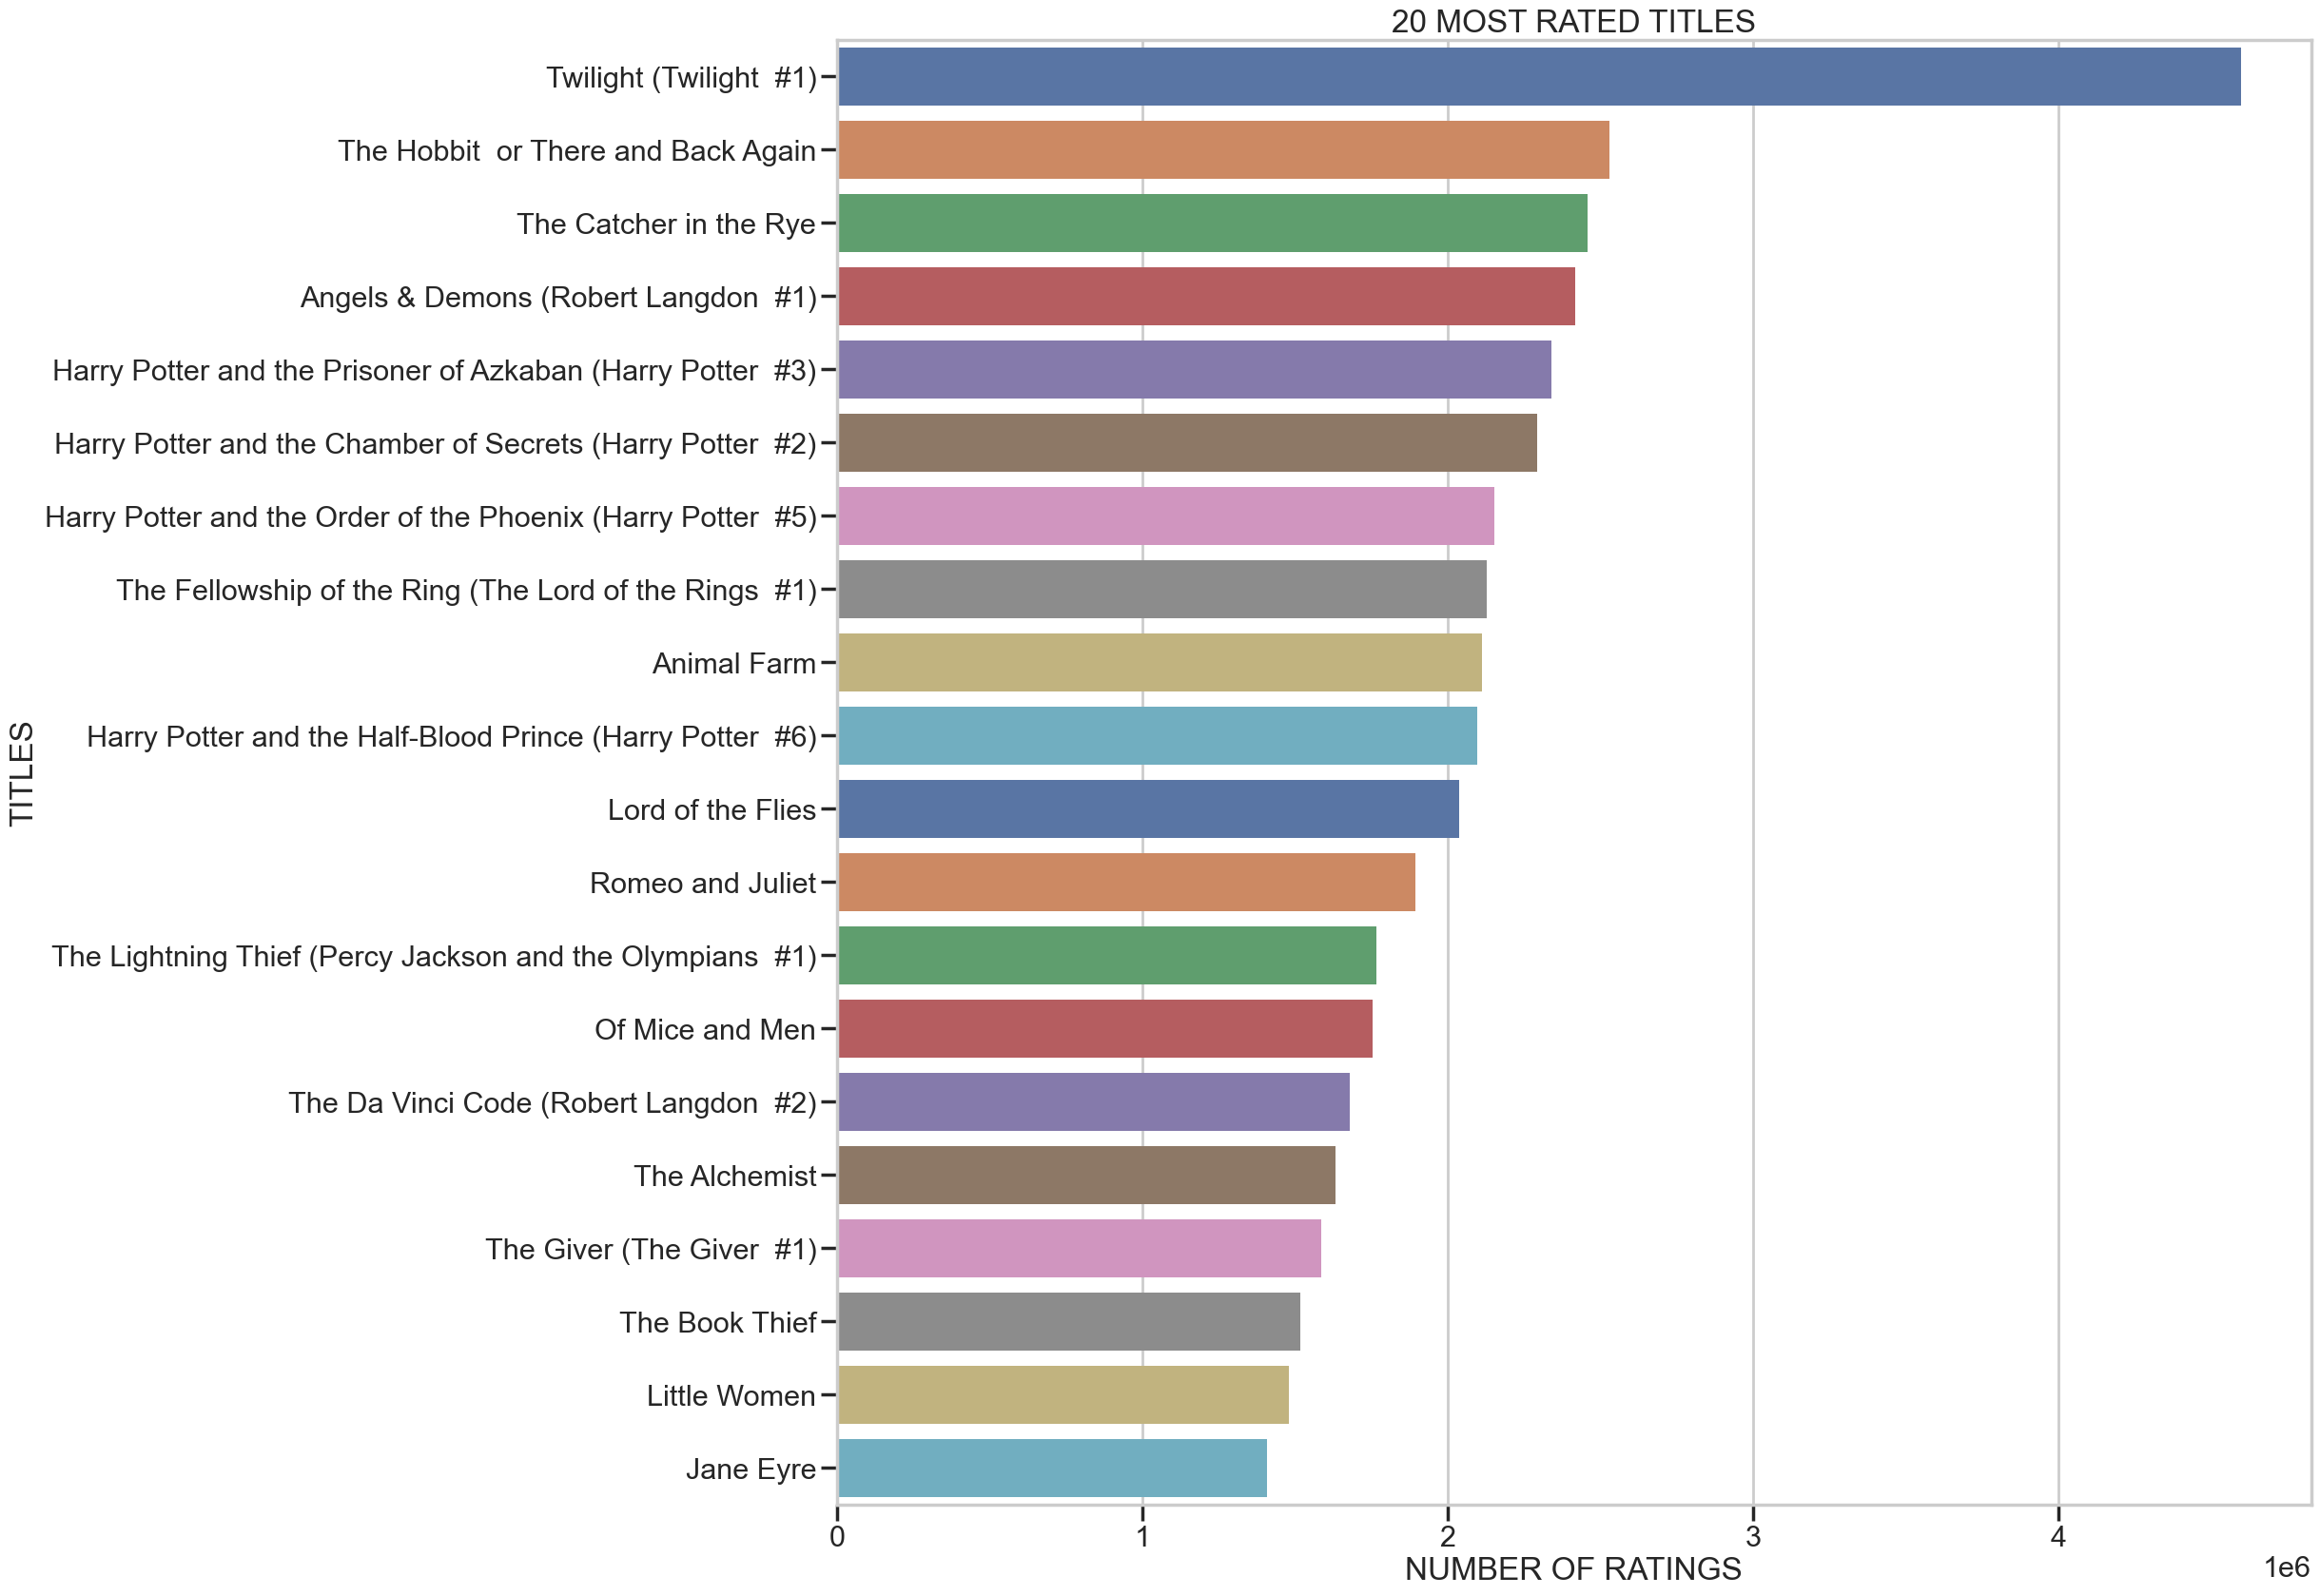

In [96]:
sns.set_context('poster')
plt.figure(figsize=(20,20))

x=most_rated_titles['ratings_count']
y=most_rated_titles['title']

sns.barplot(x=x, y=y, palette='deep')

plt.title("20 MOST RATED TITLES")
plt.xlabel("NUMBER OF RATINGS")
plt.ylabel("TITLES")
plt.show()

#### Note:
The 20 books with the most ratings consists of a mixture classic literature and newer titles such as the Harry Potter series and The Da Vinci Code.

### 20 HIGHEST RATED

the average ratings for the books that have been rated the most times in the dataset.

In [97]:
top_titles_list = most_rated_titles['title'].head(50).unique()

title_ratings = df.groupby(['title'])[['average_rating']].agg('mean').reset_index()
title_ratings =  title_ratings[title_ratings['title'].isin(top_titles_list)]
title_ratings =  title_ratings.sort_values('average_rating', ascending=False)
title_ratings =  title_ratings.reset_index().drop(['index'], axis=1)
title_ratings = title_ratings.head(25)

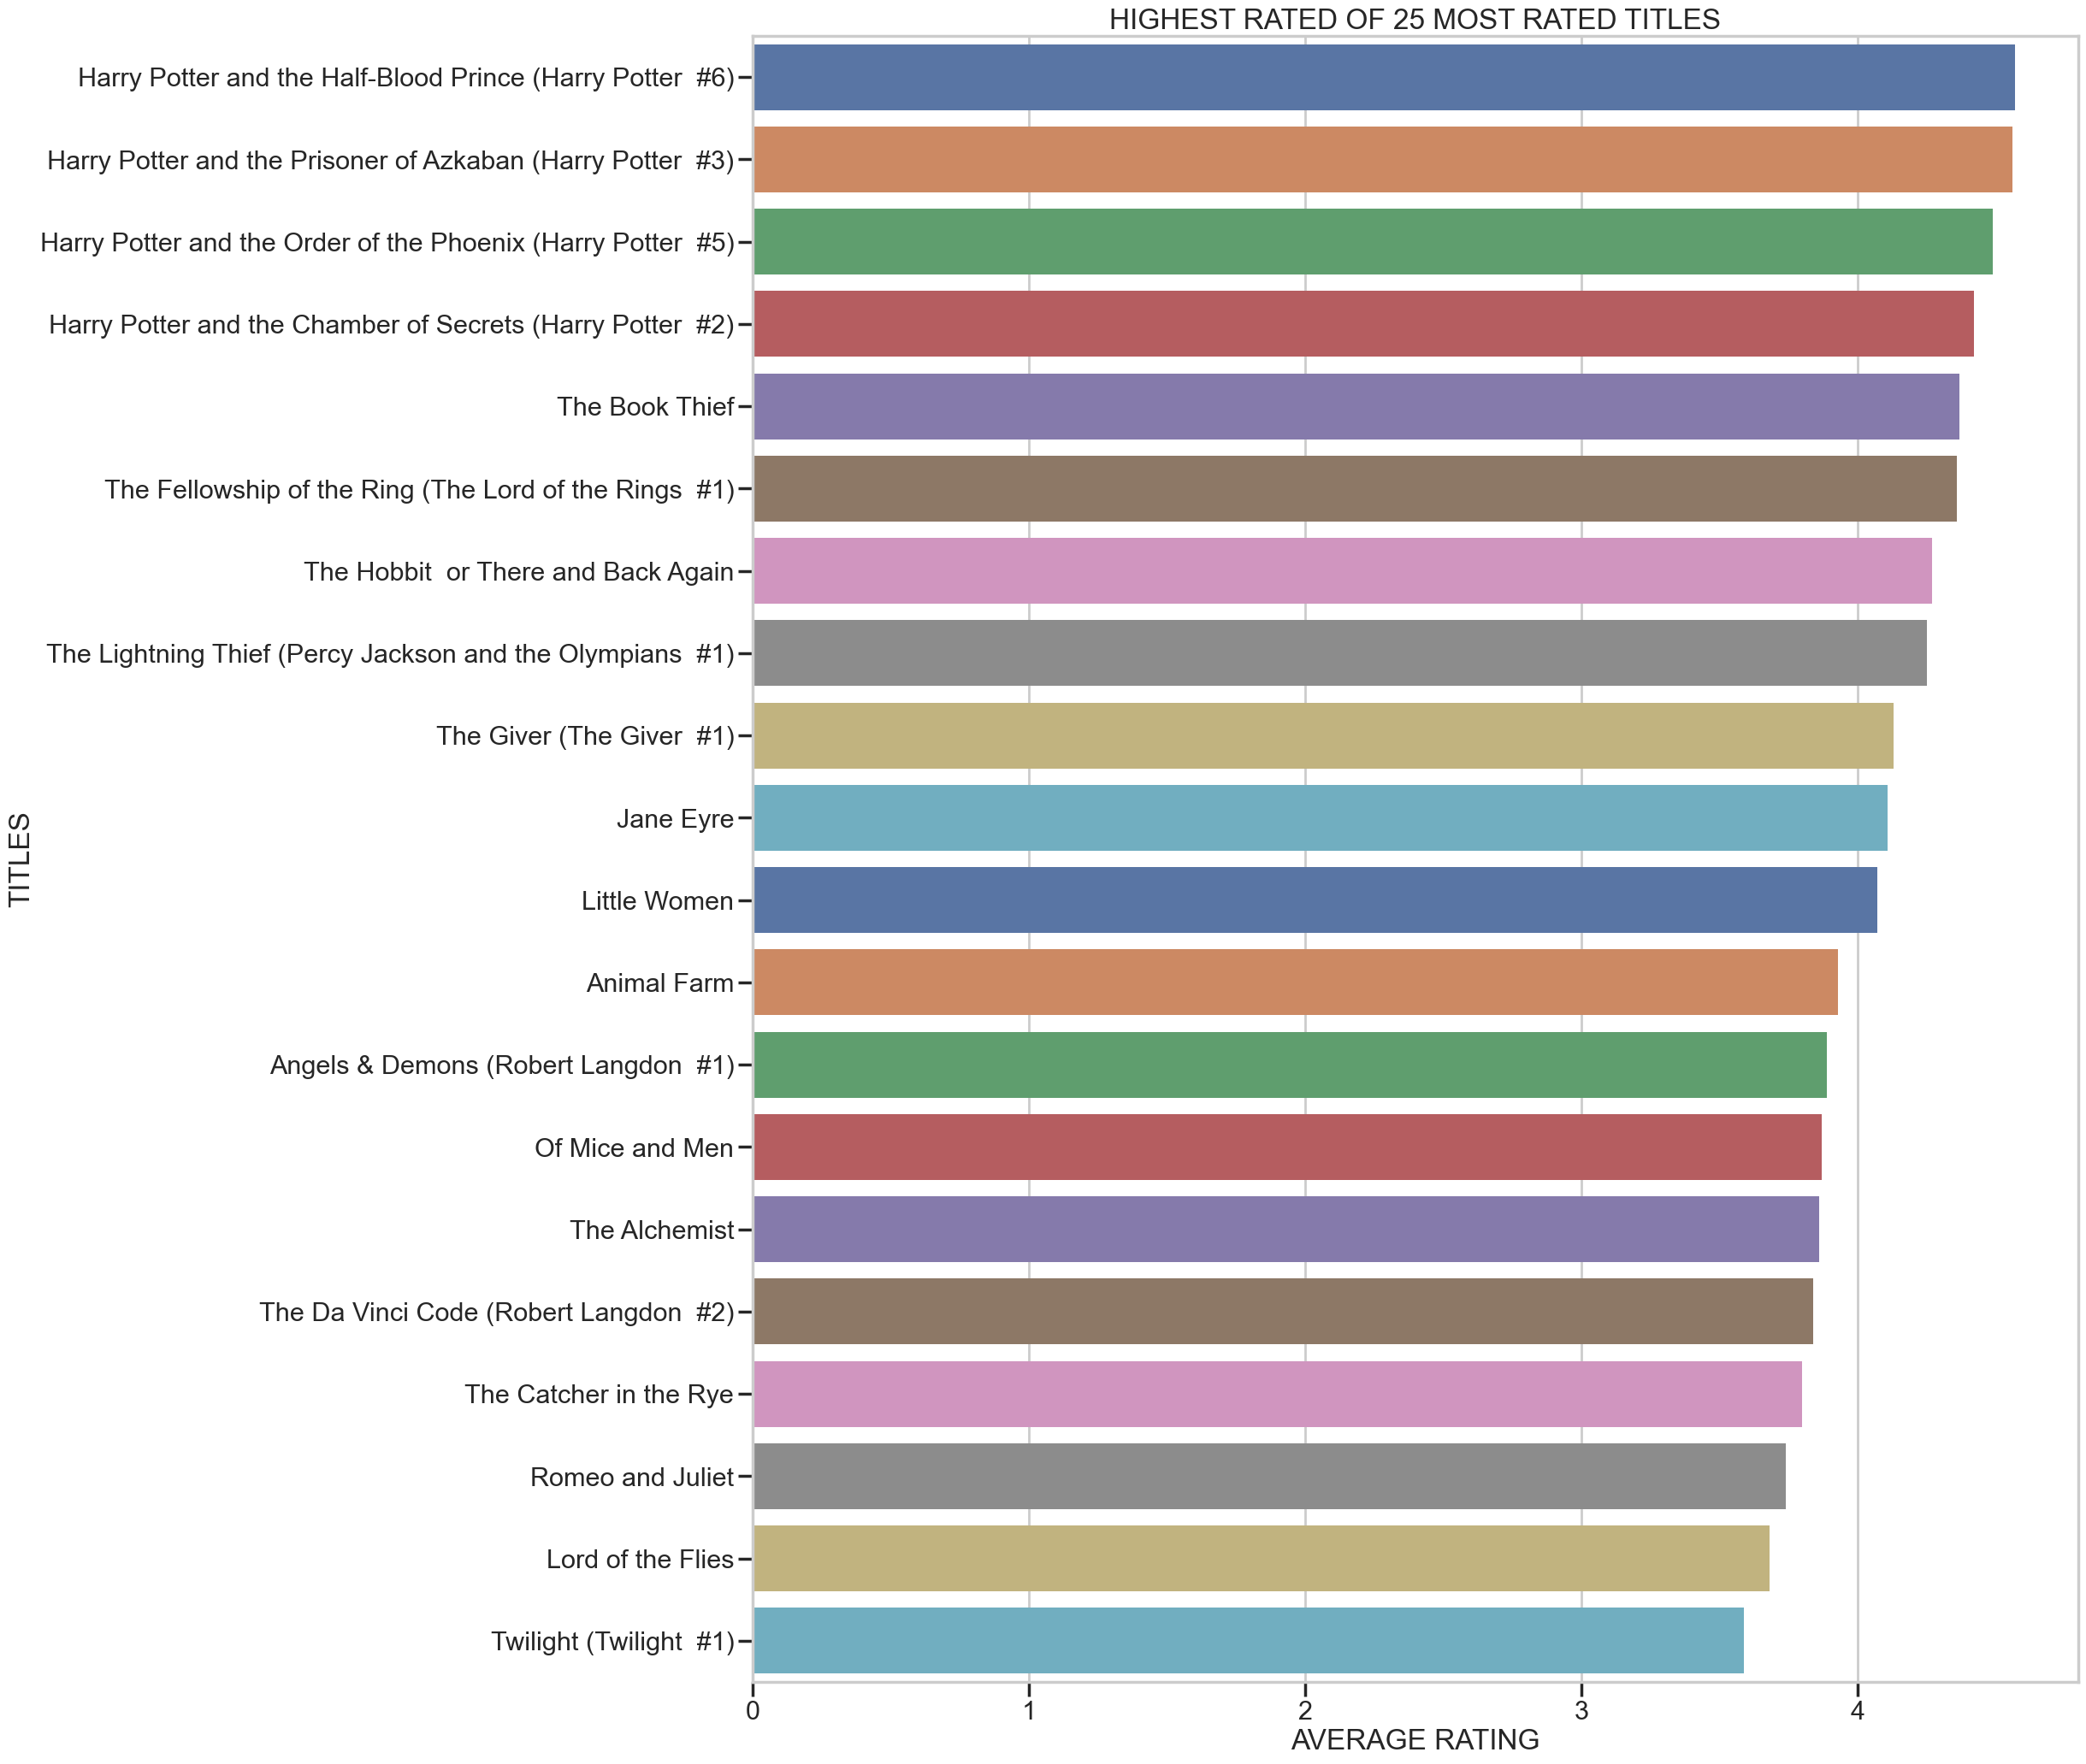

In [98]:
sns.set_context('poster')
plt.figure(figsize=(20,25))

x=title_ratings['average_rating']
y=title_ratings['title']

sns.barplot(x=x, y=y, palette='deep')

plt.title("HIGHEST RATED OF 25 MOST RATED TITLES")
plt.xlabel("AVERAGE RATING")
plt.ylabel("TITLES")
plt.show()

#### Note:
Although Twilight has the most ratings, it is not included among the books with the highest average rating.

### 20 MOST OCCURING AUTHORS

In [99]:
author_count = df[['authors']].value_counts().to_frame().reset_index()
author_count.rename(columns={0:'count'}, inplace=True)
author_count = author_count.head(20)

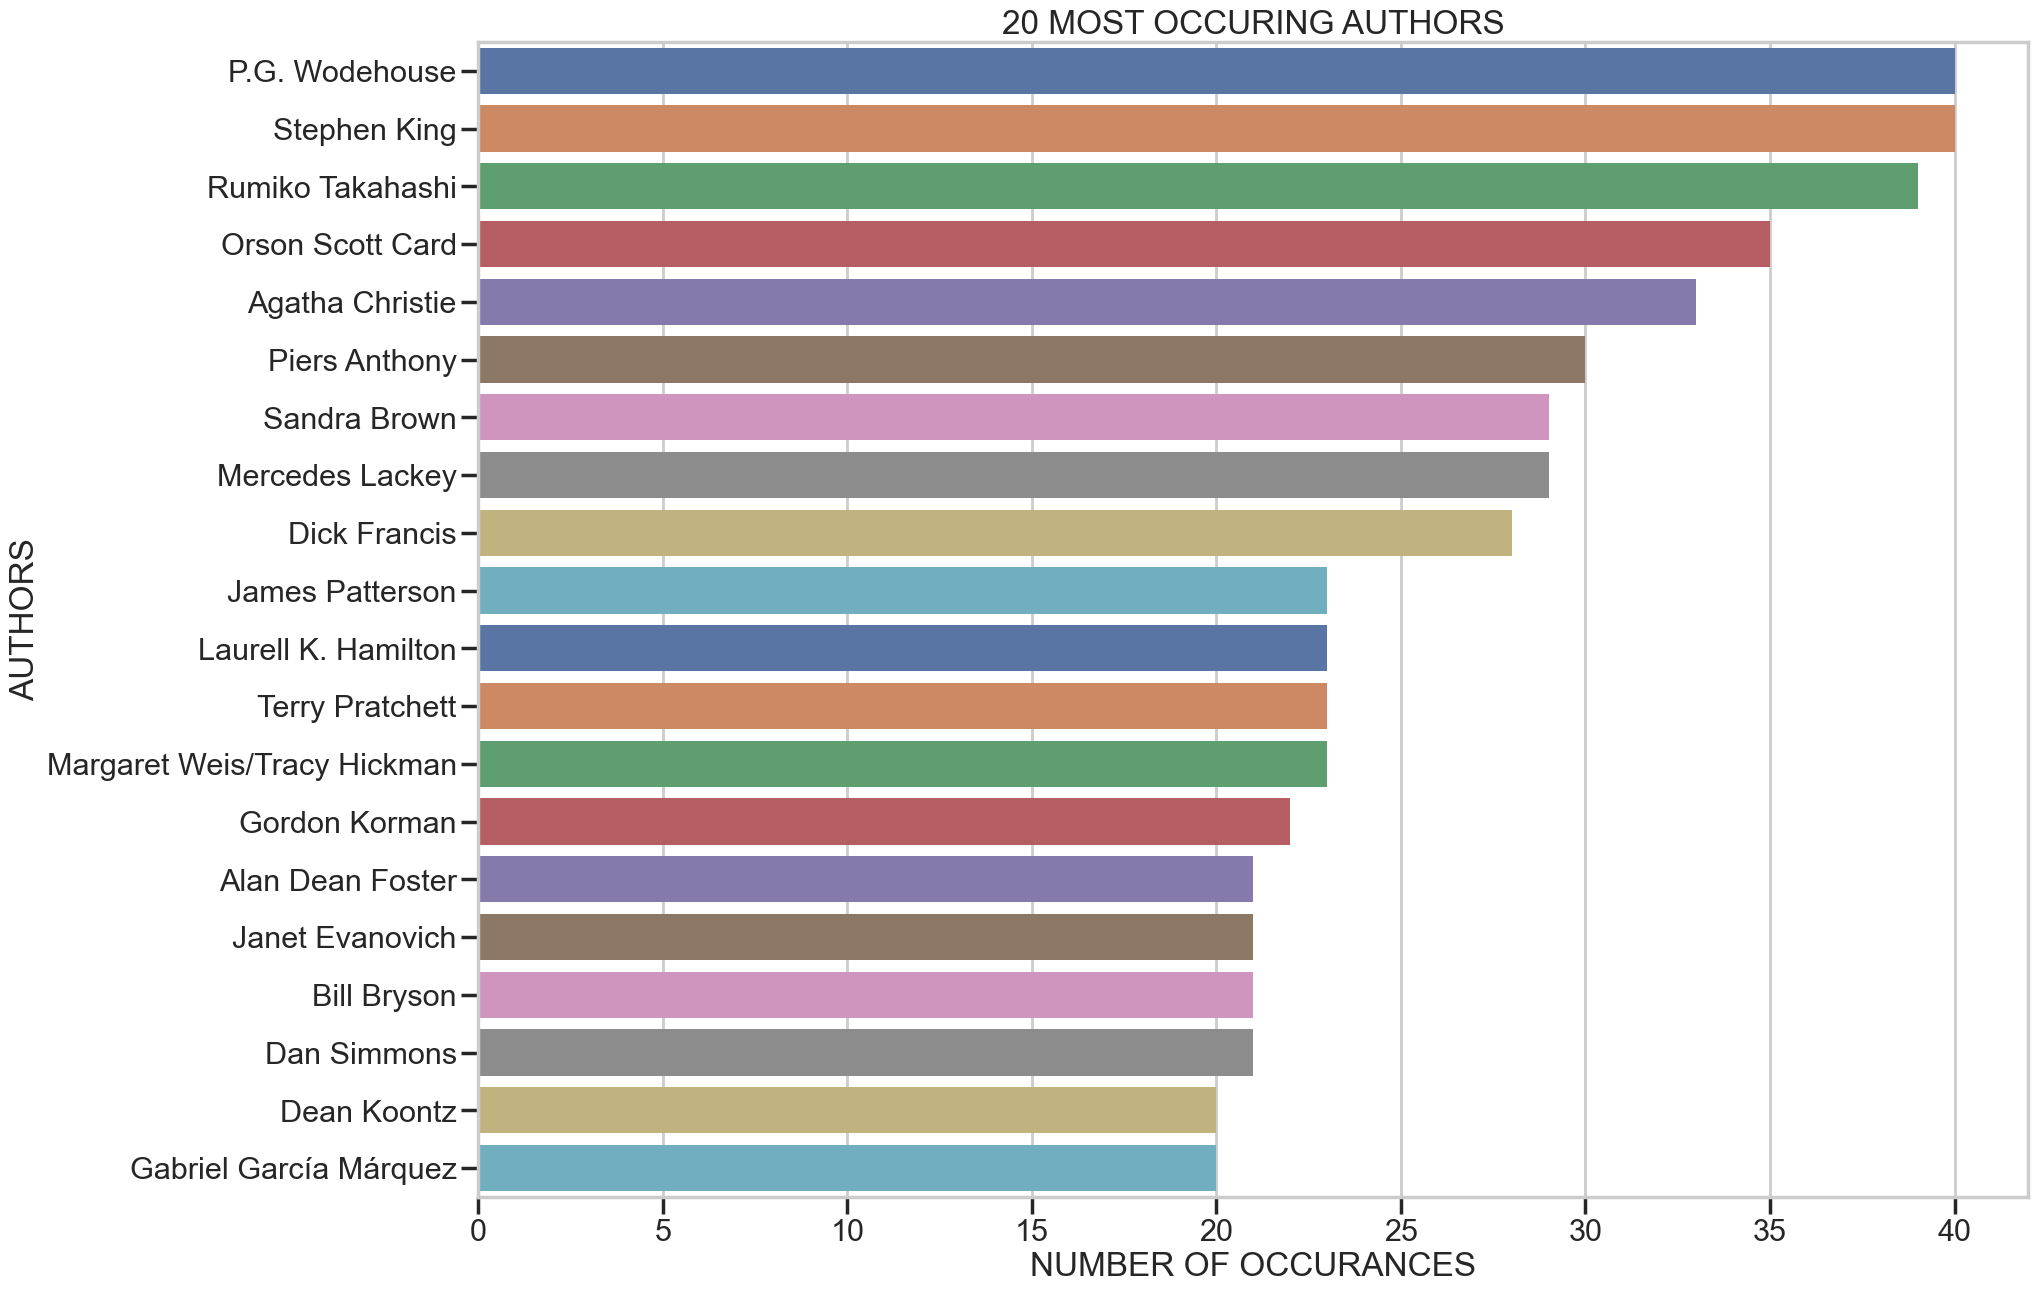

In [100]:
sns.set_context('poster')
plt.figure(figsize=(20,15))

x=author_count['count']
y=author_count['authors']

sns.barplot(x=x, y=y, palette='deep')

plt.title("20 MOST OCCURING AUTHORS")
plt.xlabel("NUMBER OF OCCURANCES")
plt.ylabel("AUTHORS")
plt.show()

### HIGHEST RATED OF 20 MOST OCCURING AUTHORS

In [101]:
most_rated_auth = author_count['authors'].head(20).unique()

auth_avg_rating = df.groupby(['authors'])[['average_rating']].agg('mean').reset_index()
auth_avg_rating = auth_avg_rating[auth_avg_rating['authors'].isin(most_rated_auth)]
auth_avg_rating = auth_avg_rating.sort_values('average_rating', ascending=False)
auth_avg_rating = auth_avg_rating.reset_index().drop(['index'], axis=1)
auth_avg_rating = auth_avg_rating.head(20)

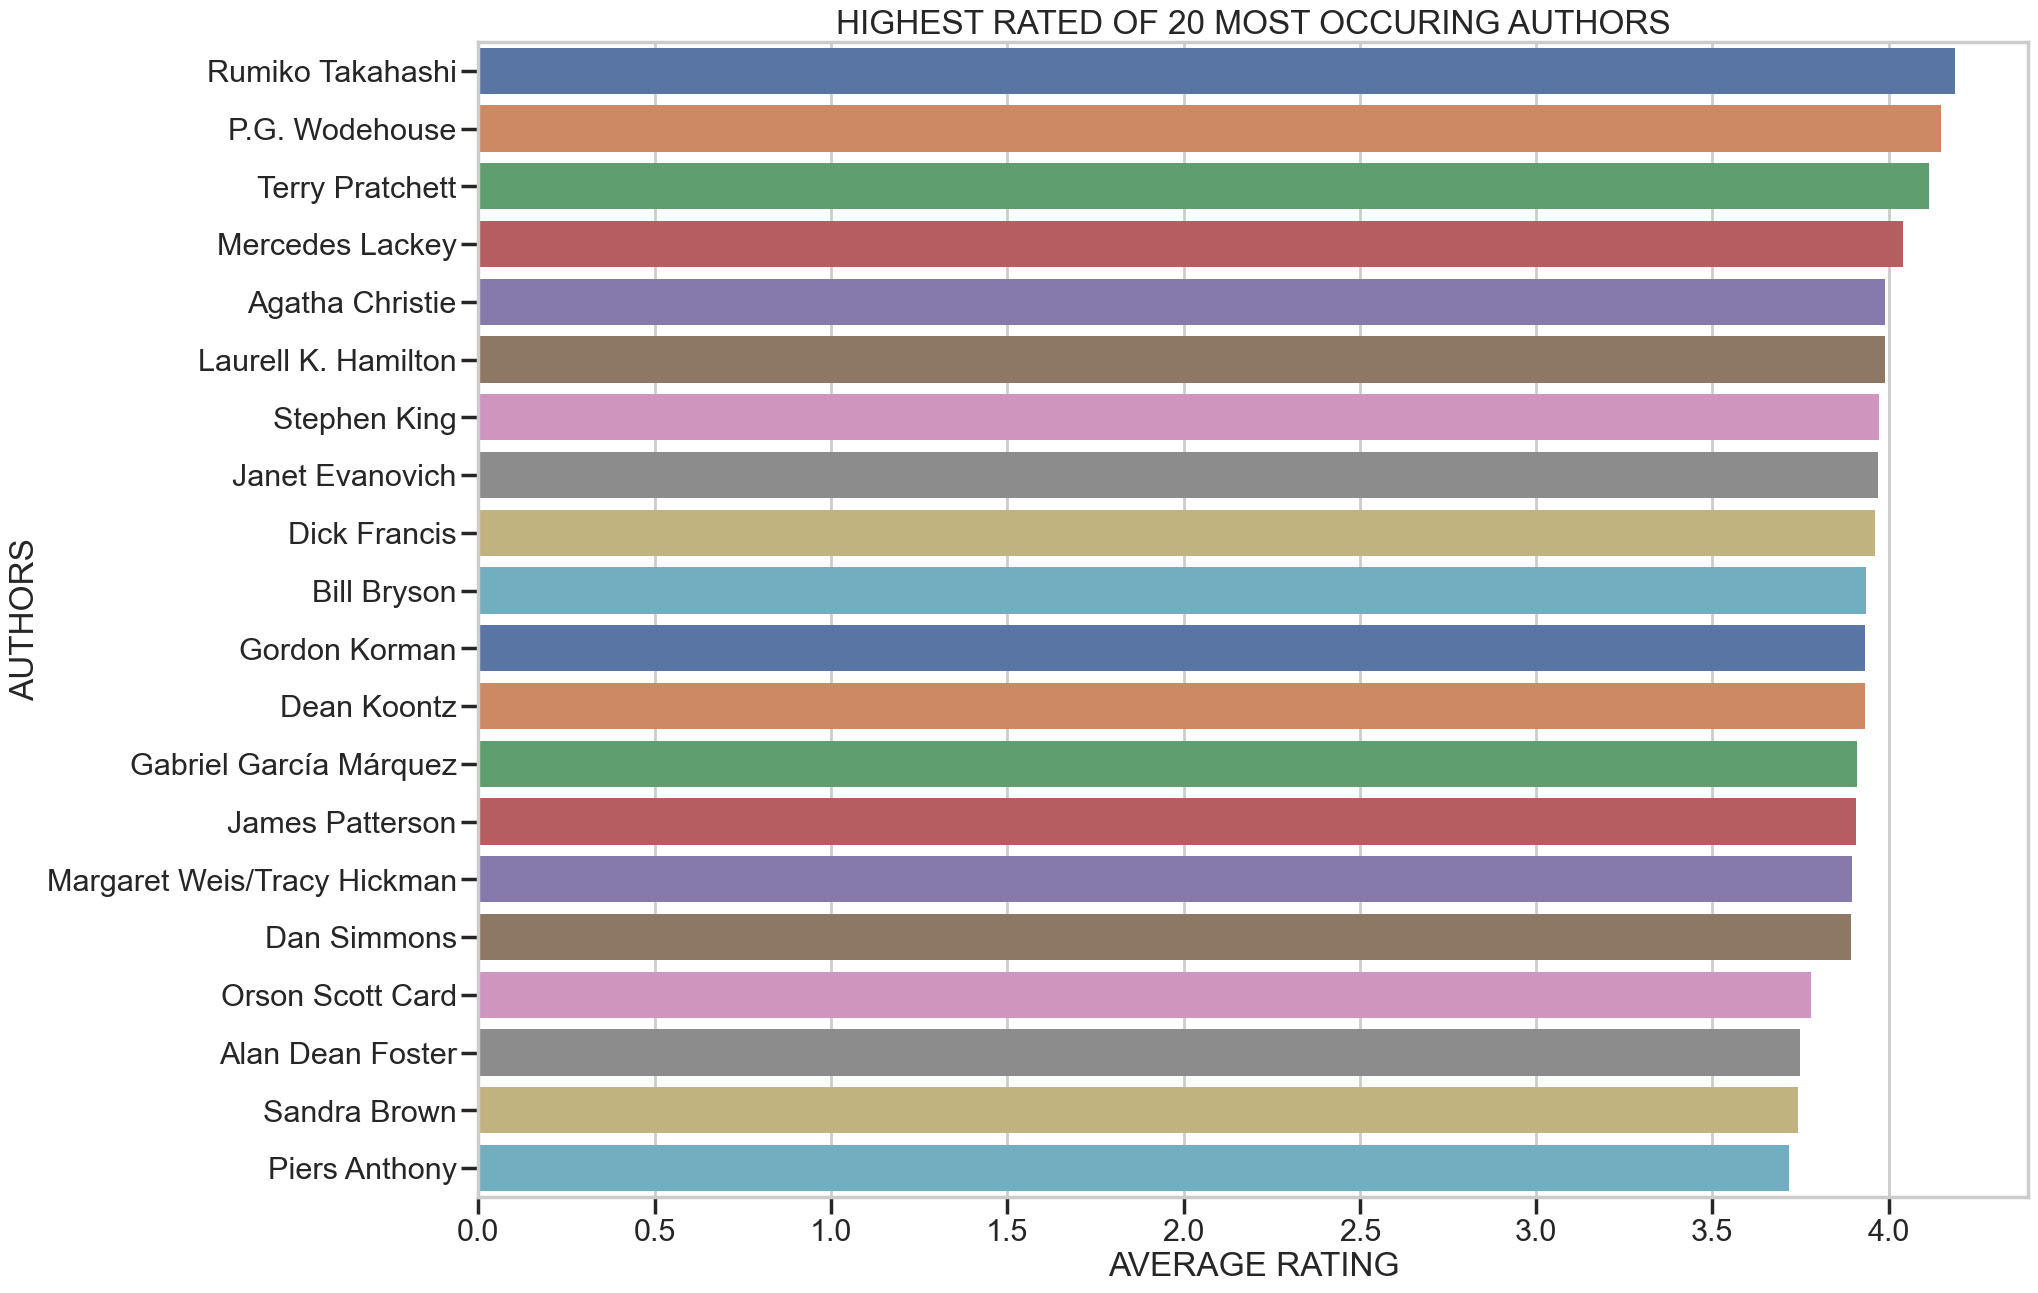

In [102]:
sns.set_context('poster')
plt.figure(figsize=(20,15))

x=auth_avg_rating['average_rating']
y=auth_avg_rating['authors']

sns.barplot(x=x, y=y, palette='deep')

plt.title("HIGHEST RATED OF 20 MOST OCCURING AUTHORS")
plt.xlabel("AVERAGE RATING")
plt.ylabel("AUTHORS")
plt.show()

### YEARS WITH MOST BOOKS LISTED

In [103]:
book_years = df.groupby(['publication_year'])[['bookID']].agg('count')
book_years.rename(columns={'bookID' : 'count'}, inplace=True)
book_years = book_years.sort_values('count', ascending=False).reset_index()
book_years = book_years.head(20)
book_years = book_years.sort_values('publication_year').reset_index().drop(['index'], axis=1)

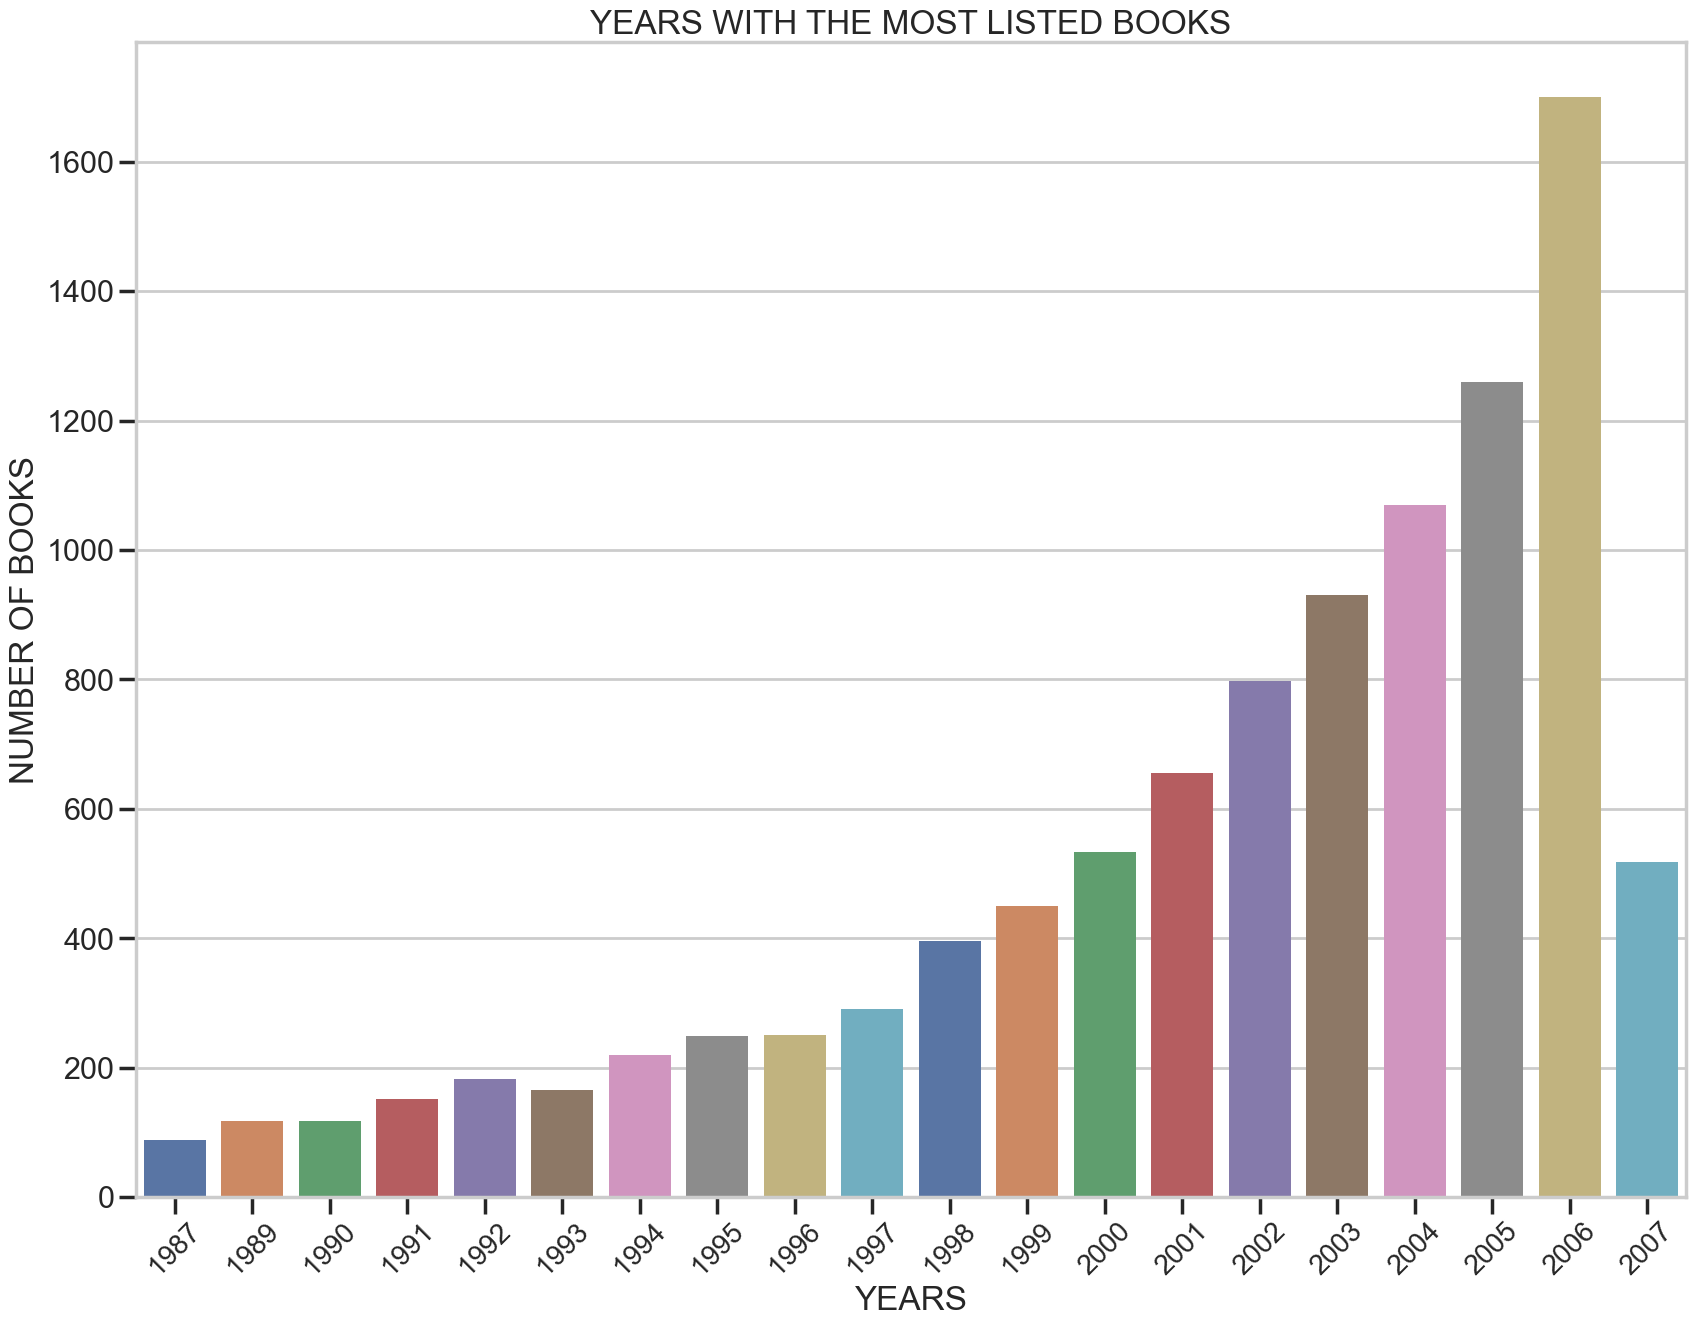

In [104]:
sns.set_context('poster')
plt.figure(figsize=(20,15))

x=book_years['publication_year']
y=book_years['count']

chart = sns.barplot(x=x, y=y, palette='deep')

plt.title("YEARS WITH THE MOST LISTED BOOKS")
plt.xlabel("YEARS")
plt.xticks(rotation=45,  horizontalalignment='center',fontweight='light',fontsize='small')
plt.ylabel("NUMBER OF BOOKS")
plt.show()

### PUBLICATION MONTH COUNT

In [105]:
rating_month = df.groupby(['publication_month', 'pub_month_name'])[['bookID']].agg('count')
rating_month = rating_month.sort_values('bookID', ascending=False).reset_index()
rating_month.rename(columns={'bookID':'book_count'}, inplace=True)
rating_month = rating_month.head(20).sort_values('publication_month')

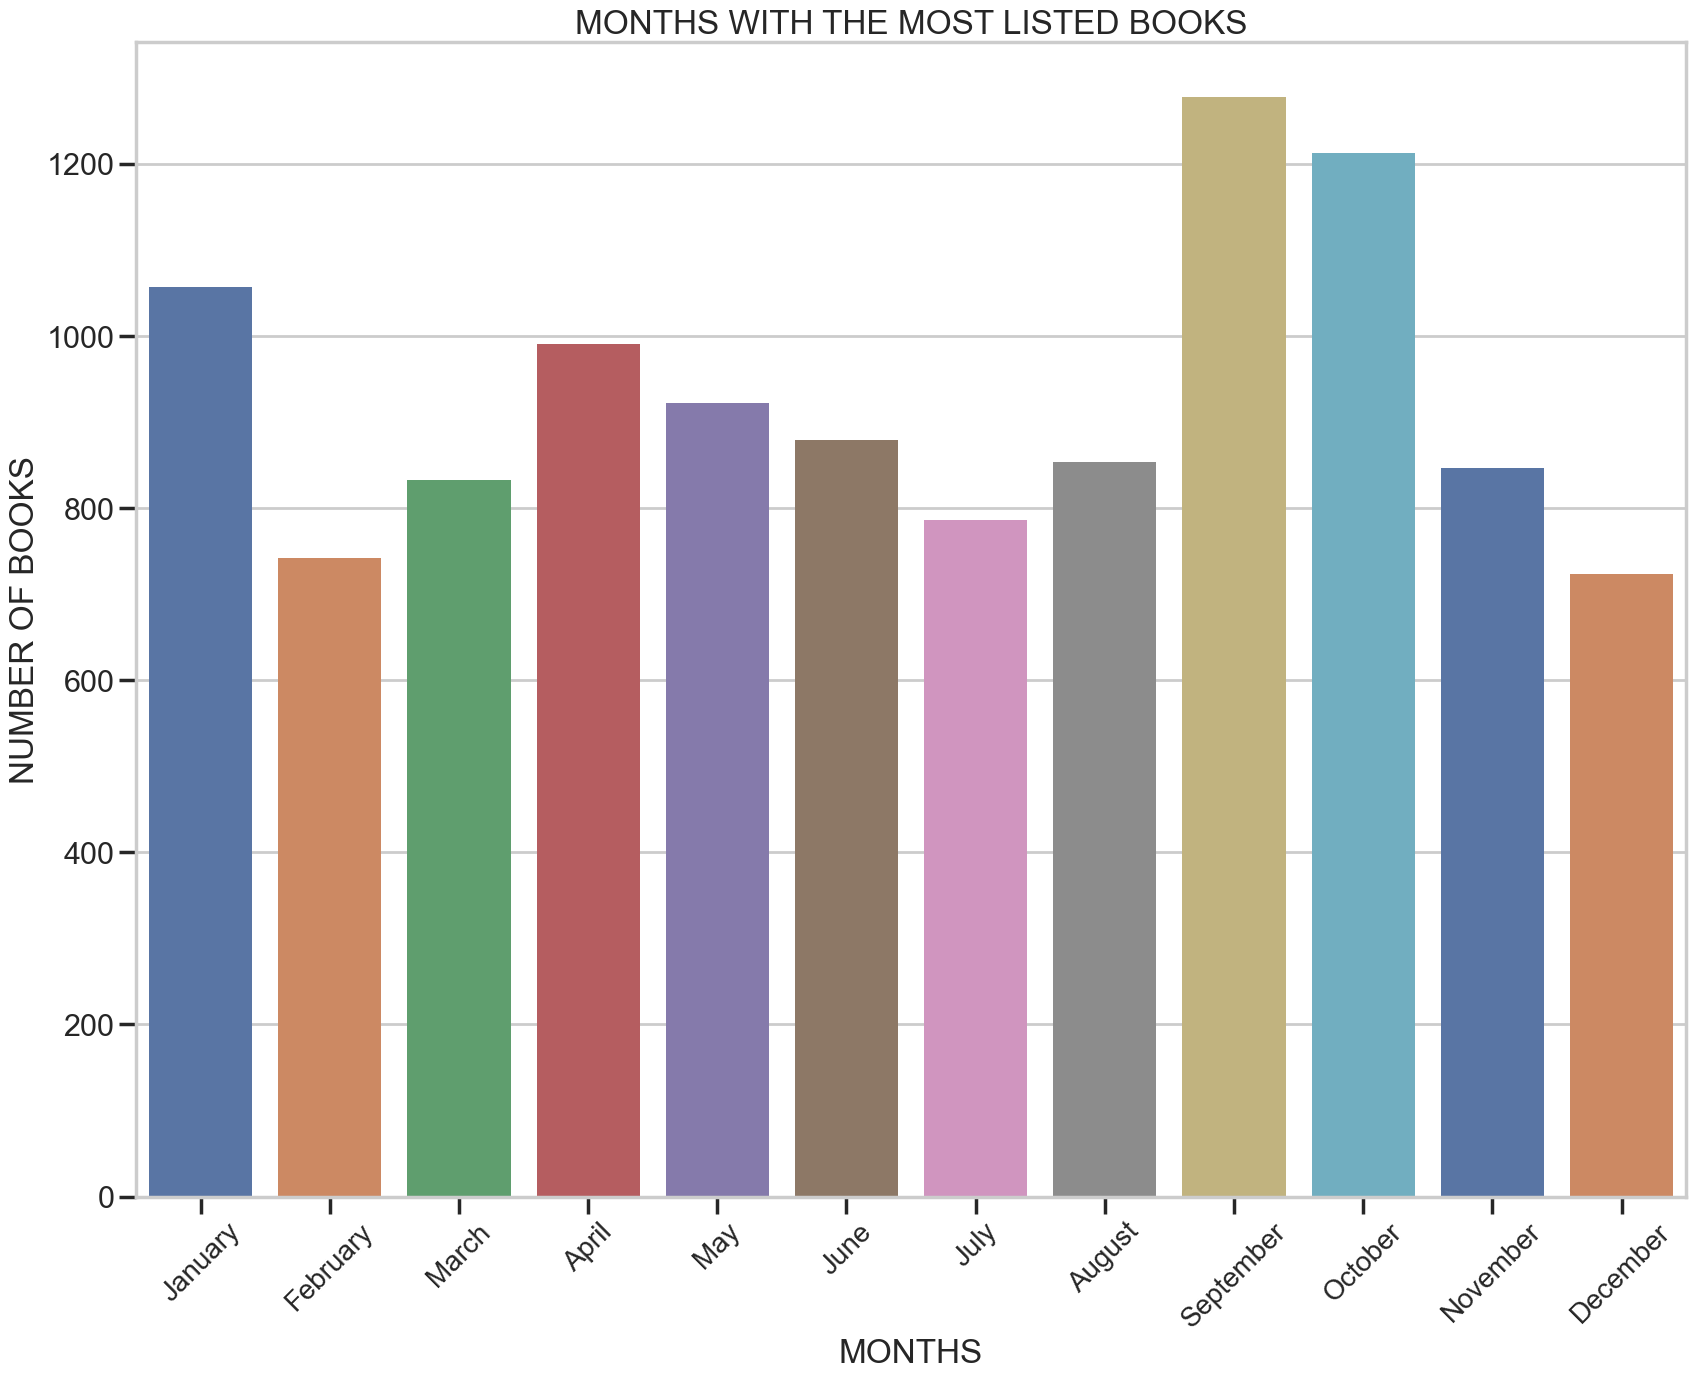

In [106]:
sns.set_context('poster')
plt.figure(figsize=(20,15))

x=rating_month['pub_month_name']
y=rating_month['book_count']

chart = sns.barplot(x=x, y=y, palette='deep')

plt.title("MONTHS WITH THE MOST LISTED BOOKS")
plt.xlabel("MONTHS")
plt.xticks(rotation=45,  horizontalalignment='center',fontweight='light',fontsize='small')
plt.ylabel("NUMBER OF BOOKS")
plt.show()

### TOP 20 PUBLISHERS WITH MOST RATINGS

In [107]:
pub_ratings_count = df.groupby(['publisher'])[['ratings_count']].agg('count')
pub_ratings_count = pub_ratings_count.sort_values('ratings_count', ascending=False).reset_index()
pub_ratings_count = pub_ratings_count.head(20)

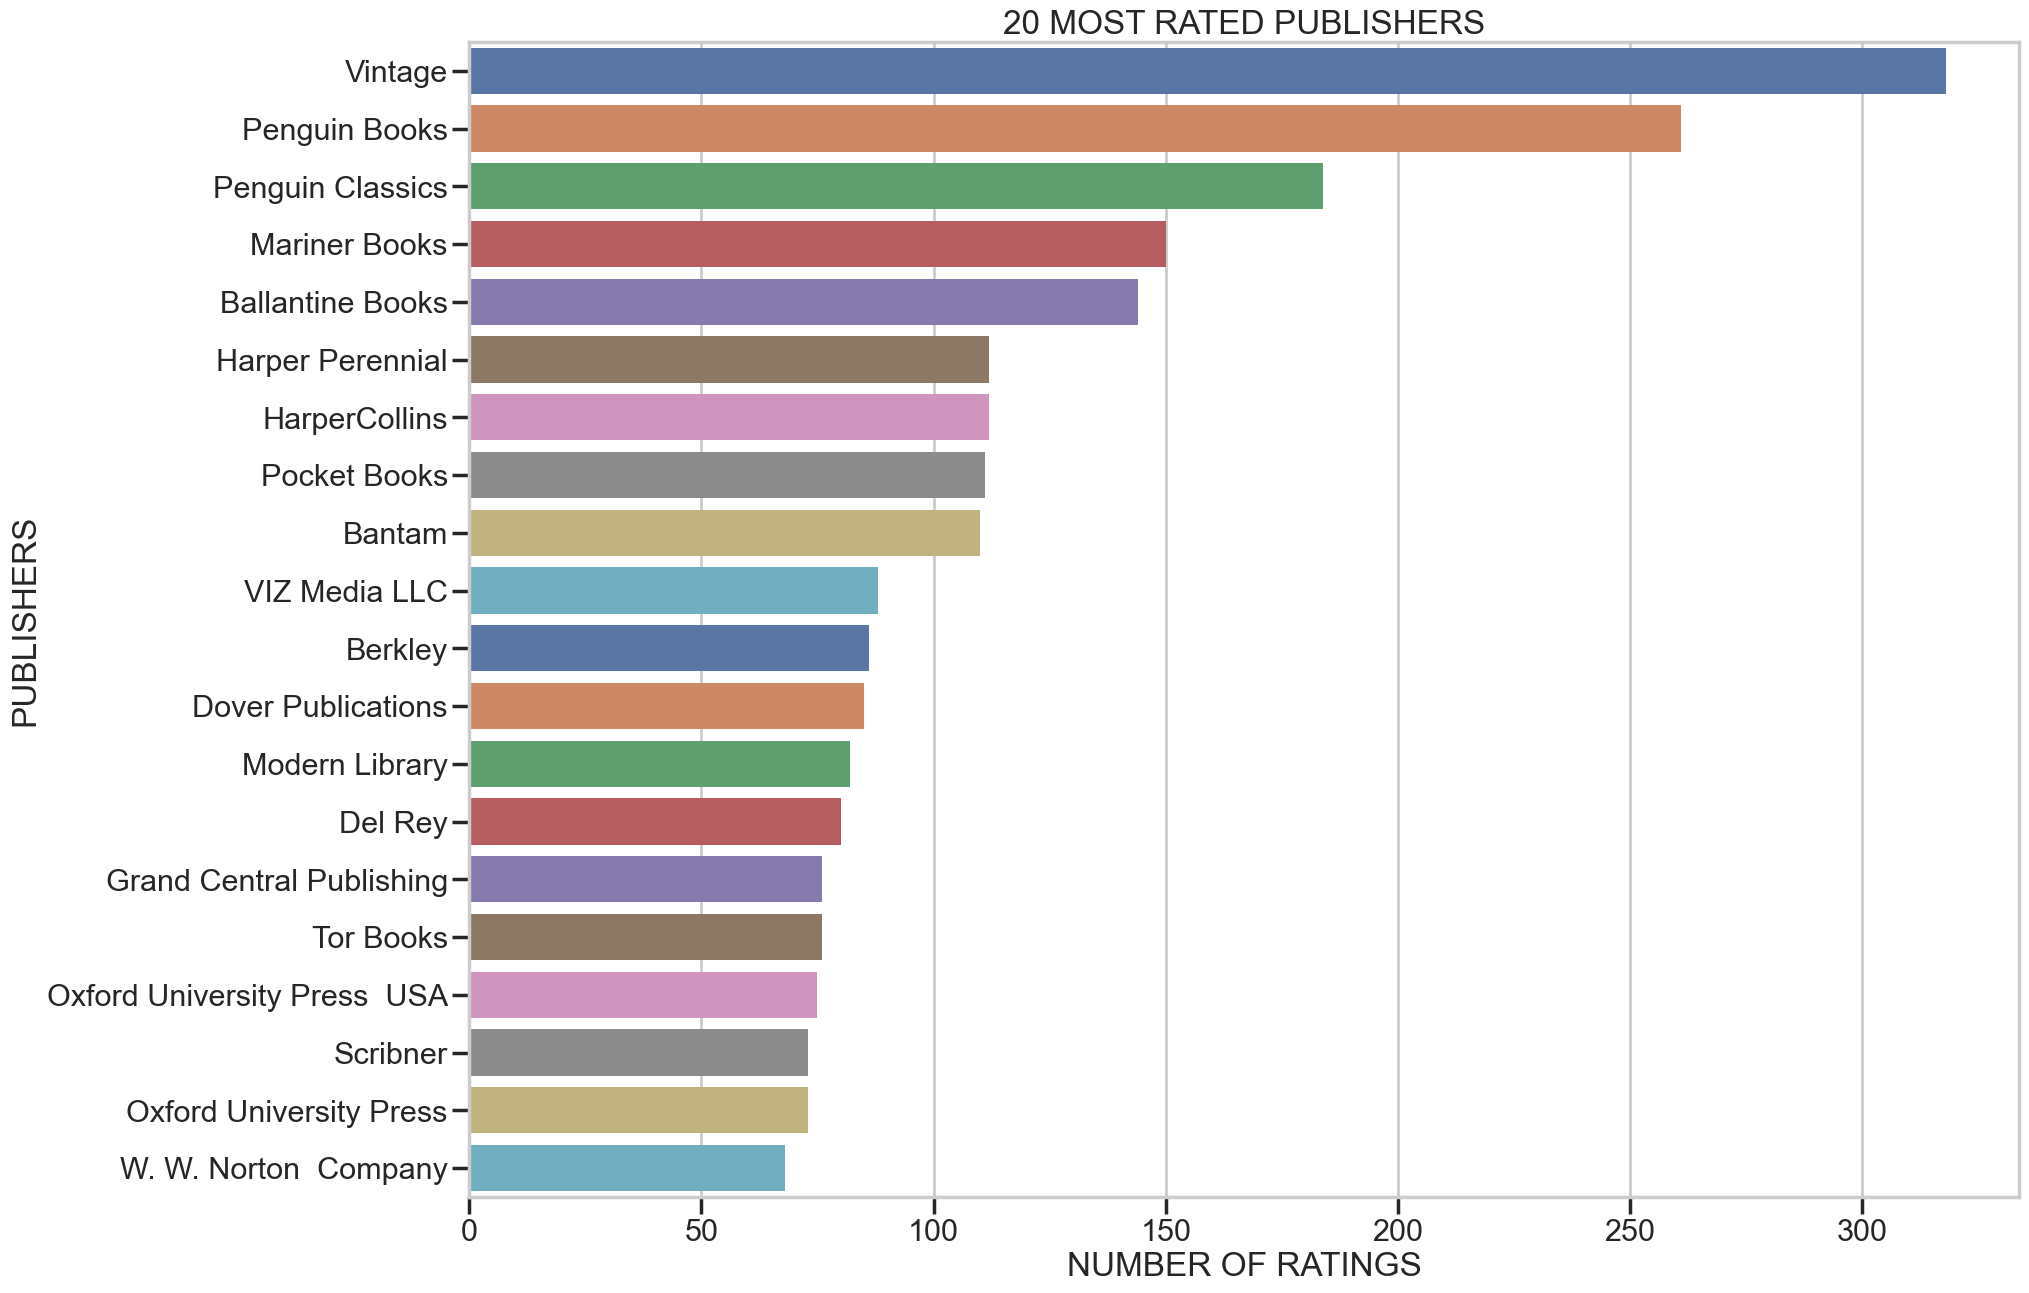

In [108]:
sns.set_context('poster')
plt.figure(figsize=(20,15))

x=pub_ratings_count['ratings_count']
y=pub_ratings_count['publisher']

sns.barplot(x=x, y=y, palette='deep')

plt.title("20 MOST RATED PUBLISHERS")
plt.xlabel("NUMBER OF RATINGS")
plt.ylabel("PUBLISHERS")
plt.show()

### HIGHEST RATED OF 20 MOST RATED PUBLISHERS

In [109]:
most_rated_pub = pub_ratings_count['publisher'].head(20).unique()

pub_avg_ratings = df.groupby(['publisher'])[['average_rating']].agg('mean').reset_index()
pub_avg_ratings = pub_avg_ratings[pub_avg_ratings['publisher'].isin(most_rated_pub)]
pub_avg_ratings = pub_avg_ratings.sort_values('average_rating', ascending=False)
pub_avg_ratings = pub_avg_ratings.reset_index().drop(['index'], axis=1)

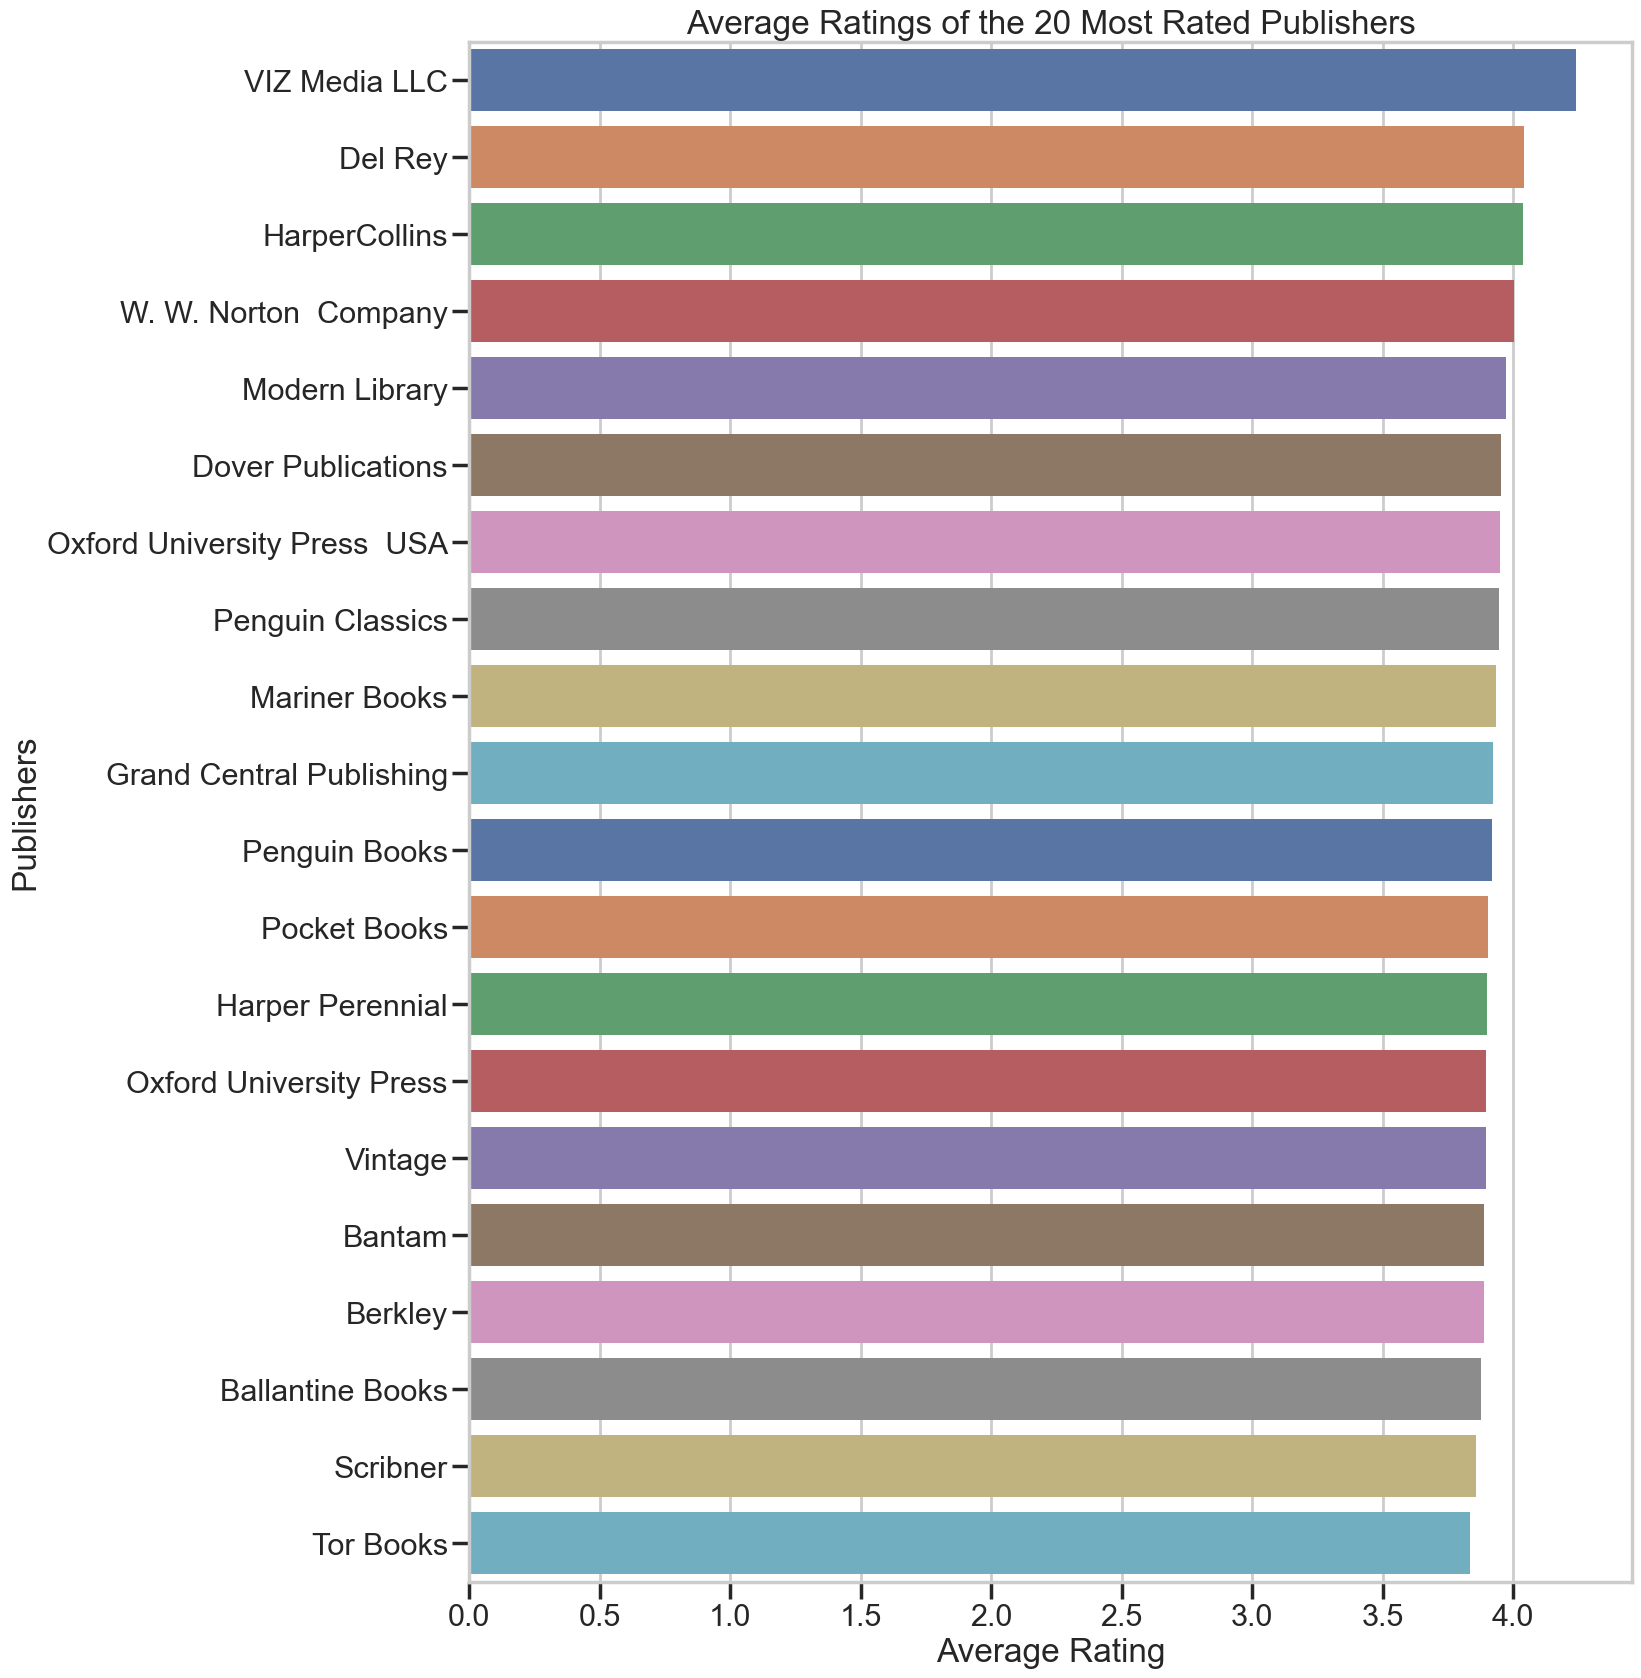

In [110]:
sns.set_context('poster')
plt.figure(figsize=(15,20))

x=pub_avg_ratings['average_rating']
y=pub_avg_ratings['publisher']

sns.barplot(x=x, y=y, palette='deep')

plt.title("Average Ratings of the 20 Most Rated Publishers")
plt.xlabel("Average Rating")
plt.ylabel("Publishers")
plt.show()

### LANGUAGE DISTRIBUTION

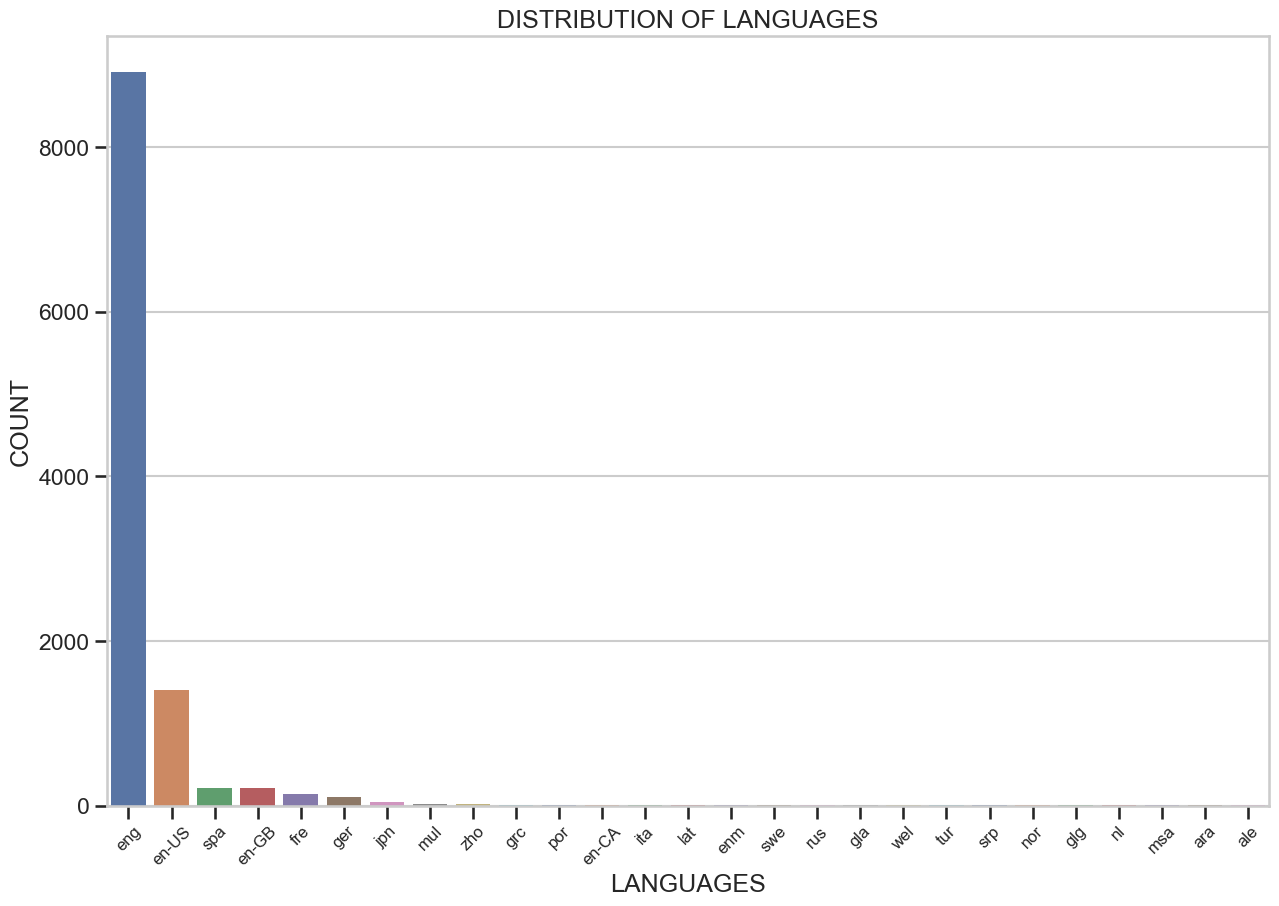

In [111]:
languages = df.groupby(['language_code'])[['title']].agg('count')
languages = languages.rename(columns={'title':'count'}).reset_index()
languages = languages.sort_values('count', ascending=False)

sns.set_context('talk')
plt.figure(figsize=(15,10))

sns.barplot(x="language_code", y='count', data=languages, palette='deep')

plt.title("DISTRIBUTION OF LANGUAGES")
plt.xlabel("LANGUAGES")
plt.xticks(rotation=45,  horizontalalignment='center',fontweight='light',fontsize='12')

plt.ylabel("COUNT")
plt.show()

### PLOTTING RATINGS DISTRIBUTION

Binning the average ratings into categories gives us a general overview of the ratings trends for the entire dataset.

In [46]:
fig = px.pie(df, values='average_rating', names='ratings_binned')
fig.show()

### BIVARIATE ANALYSIS

#### AVERAGE RATING & NUMBER OF PAGES

In this visualization we will plot the number of pages in a book as compared to it's average rating.

In [112]:
fig = px.scatter(x=df['average_rating'], y=df['  num_pages'])

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='CORRELATION: AVERAGE RATING & NUM OF PAGES',
                  yaxis_title='NUM OF PAGES',
                  xaxis_title='AVERAGE RATING', 
                  title_x=0.5,
                  width = 750,
                  height=500)
fig.show()

C:\Users\alhai\anaconda3\envs\myenv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



<Figure size 1500x1000 with 0 Axes>

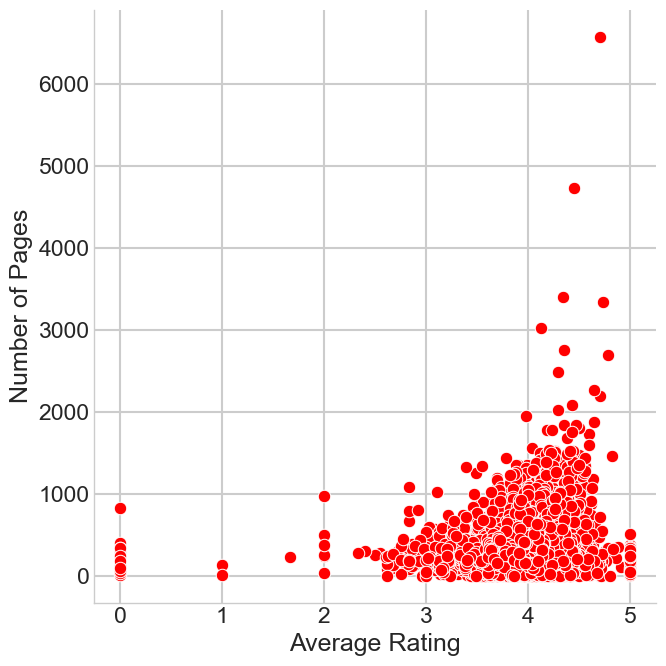

In [120]:
plt.figure(figsize=(15,10))
ax = sns.relplot(x="average_rating", y="  num_pages", data = df, color = 'red',sizes=(100, 200), height=7, marker='o')
ax.set_axis_labels("Average Rating", "Number of Pages")

### Notes:
- Based on the above visualization the majority of books have less than 500 pages with average ratings between 3 and 4.
- Books between 500 and 1500 pages are mostly rated in the 3.5 to 4.5 range. However, as the page numbers trend upward there is a slight increase in the ratings as well.
- The few books with pages numbering above 1500 are mostly all rated above 4.0, yet most of the books rated above 4.5 have less than 500 pages.
- Based on the above observations a causal relationship between the two variables is unable to be determined.

### AVERAGE RATING & RATINGS COUNT

In [48]:
fig = px.scatter(x=df['average_rating'], y=df['ratings_count'])

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='CORRELATION: AVERAGE RATING & RATINGS COUNT',
                  yaxis_title='ratings_count',
                  xaxis_title='AVERAGE RATING', 
                  title_x=0.5,
                  width = 750,
                  height=500)
fig.show()

C:\Users\alhai\anaconda3\envs\myenv\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



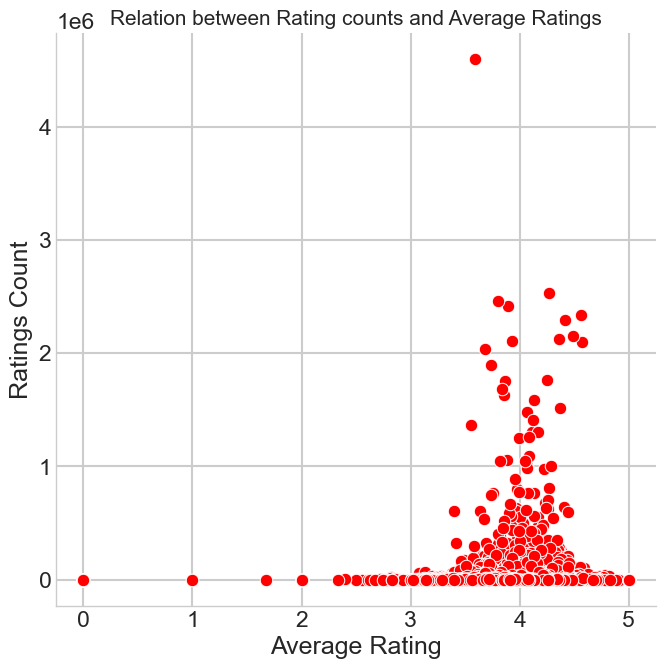

In [118]:
ax = sns.relplot(data=df, x="average_rating", y="ratings_count", color = 'red', sizes=(100, 200), height=7, marker='o')
plt.title("Relation between Rating counts and Average Ratings",fontsize = 15)
ax.set_axis_labels("Average Rating", "Ratings Count")

### Note:
The higher ratings count values exist within the 3.5 to 4.5 average rating range. This may possibly indicate a correlation between higher ratings counts and average ratings.

In [49]:
sample = df[df['ratings_count']<20000]

fig = px.scatter(x=sample['average_rating'], y=sample['ratings_count'])

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='CORRELATION: AVERAGE RATING & RATINGS COUNT',
                  yaxis_title='ratings_count',
                  xaxis_title='AVERAGE RATING', 
                  title_x=0.5,
                  width = 750,
                  height=500)
fig.show()

### Notes:
- The higher ratings count values exist within the 3.5 to 4.5 average rating range. This may possibly indicate a correlation between higher ratings counts and average ratings.
- When zooming in to the range below 20,000 ratings counts we see that as the ratings counts increase, they are more concentrated around the average rating value of 4.

### CORRELATION: RATINGS BINS & TEXT REVIEWS COUNT

By using the ratings bins we're able to get a more general picture of the relationship between the number of text reviews a book has and its rating.

For a more in depth look, we'll also look at the individual ratings compared to the text review counts.

In [113]:
ratings_reviews = df[['text_reviews_count', 'ratings_binned']].sort_values('text_reviews_count', ascending=False)
# ratings_reviews

In [114]:
fig = px.scatter(x=ratings_reviews['ratings_binned'], y=ratings_reviews['text_reviews_count'])

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='CORRELATION: AVERAGE RATING & TEXT REVIEWS COUNT',
                  yaxis_title='TEXT REVIEWS COUNT',
                  xaxis_title='AVERAGE RATING BINS', 
                  title_x=0.5,
                  width = 750,
                  height=500)
fig.show()

In [52]:
fig = px.scatter(x=df['average_rating'], y=df['text_reviews_count'])

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='CORRELATION: AVERAGE RATING & TEXT REVIEWS COUNT',
                  yaxis_title='TEXT REVIEWS COUNT',
                  xaxis_title='AVERAGE RATING', 
                  title_x=0.5,
                  width = 750,
                  height=500)
fig.show()

### Note:
Because the titles with the higher text review counts are consistently in the 3.5 - 4.5 range there might be a direct relationship between the two variables.

### CORRELATION: RATING & YEAR OF PUBLICATION

In [53]:
fig = px.scatter(x=df['average_rating'], y=df['publication_year'])

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout(title_text='CORRELATION: RATING & YEAR OF PUBLICATION',
                  yaxis_title='YEAR OF PUBLICATION',
                  xaxis_title='AVERAGE RATING', 
                  title_x=0.5,
                  width = 750,
                  height=500)
fig.show()

### Notes:
- Books published before 1960 tend to be almost exclusively rated above 3.5
- The highest rated books were published more recently.
- Because the dataset contains many duplicate titles with different publication dates, the relationship between the two variables is more difficult to determine.

In [71]:
# import necessary pakages for k-nearest-neighbour

from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [72]:
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(features)

In [73]:
model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
model.fit(features)
dist, idlist = model.kneighbors(features)

In [74]:
def book_recommendation_engine(book_name):
    book_list_name = []
    book_id = df2[df2['title'] == book_name].index
    book_id = book_id[0]
#     print('book_id', book_id)
    for newid in idlist[book_id]:
#         print(newid)
        book_list_name.append(df2.loc[newid].title)
#         print(new_data.loc[newid].title)
    return book_list_name

In [75]:
book_list_name = book_recommendation_engine('Little Women')
book_list_name

['Little Women',
 'Jane Eyre',
 'The Giver (The Giver  #1)',
 'Memoirs of a Geisha',
 "Charlotte's Web",
 'Atlantic Shift']

In [38]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
features = min_max_scaler.fit_transform(features)

In [39]:
from sklearn.decomposition import TruncatedSVD
model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
#model = TruncatedSVD()
#model = KMeans()
model.fit(features)
dist, idlist = model.kneighbors(features)

In [29]:
def BookRecommender(book_name):
    book_list_name = []
    book_id = df2[df2['title'] == book_name].index
    book_id = book_id[0]
    for newid in idlist[book_id]:
        book_list_name.append(df2.loc[newid].title)
    return book_list_name

In [31]:
BookNames = BookRecommender('Harry Potter and the Half-Blood Prince (Harry Potter  #6)')
BookNames

['Harry Potter and the Half-Blood Prince (Harry Potter  #6)',
 'Harry Potter and the Order of the Phoenix (Harry Potter  #5)',
 'The Fellowship of the Ring (The Lord of the Rings  #1)',
 'Harry Potter and the Chamber of Secrets (Harry Potter  #2)',
 'Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)',
 'The Lightning Thief (Percy Jackson and the Olympians  #1)']

### CONCLUSION
The Goodreads dataset has a lot of useful information for determining which factors may influence a book's rating and for general exploration of facts about a book.

We were able to look at variables such as publisher, date of publication, number of ratings, number of text reviews, and compare them to the average rating.

